In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import PatchTSTConfig, PatchTSTForPrediction
import torch.optim as optim

## 데이터 로드

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask df. df into pandas dfframe.

In [39]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [47]:
df['Volume'].replace(0, np.nan, inplace=True)

# 시간대별 평균 거래량 계산
df['Hour'] = pd.to_datetime(df['Datetime']).dt.hour
hourly_mean_volume = df.groupby('Hour')['Volume'].mean()

# 9시의 경우, 9시의 평균 거래량으로 대체
df['Volume'] = df.apply(lambda row: hourly_mean_volume[row['Hour']] if np.isnan(row['Volume']) else row['Volume'], axis=1)

df.drop('Hour', axis=1, inplace=True)

df['Volume']=df['Volume'].astype('int')

In [48]:
df

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-04-06 09:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,4502820
1,2022-04-06 10:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2,2022-04-06 11:00:00+09:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
3,2022-04-06 12:00:00+09:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
4,2022-04-06 13:00:00+09:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688
...,...,...,...,...,...,...,...
2955,2024-04-05 10:00:00+09:00,84700.0,84800.0,83800.0,84000.0,84000.0,3548675
2956,2024-04-05 11:00:00+09:00,83900.0,84300.0,83900.0,84200.0,84200.0,1732644
2957,2024-04-05 12:00:00+09:00,84300.0,84500.0,84100.0,84400.0,84400.0,1052082
2958,2024-04-05 13:00:00+09:00,84400.0,84500.0,84000.0,84100.0,84100.0,1295631


In [49]:
class Mymodel(nn.Module):
    def __init__(self, model):
        super(Mymodel, self).__init__()
        self.patch_tst = model
        self.fc=nn.Linear(model.config.num_input_channels, 1)
        # 가정: PatchTSTForPrediction의 출력 차원이 config.output_dim으로 주어짐

    def forward(self, x):
        # PatchTST 모델을 통과시킨 후의 출력
        x = self.patch_tst(past_values=x).prediction_outputs
        # 완전연결 계층을 통과시켜 최종 출력을 얻음
        x = self.fc(x)
        return x

In [114]:
class Stock:
    def __init__(self, df):
        super(Stock, self).__init__()
        self.df=df.copy()
        self.scaler_all = MinMaxScaler(feature_range=(0,1))
        self.scaler_target = MinMaxScaler(feature_range=(0,1))
        self.data=df.values
        self.predictions = []  # 예측값을 저장할 리스트
        self.actuals = []  # 실제값을 저장할 리스트
        self.train_losses = []
        self.val_losses = []

    def preprocessing(self):
        # index를 날짜로 설정
        self.df["Datetime"] = pd.to_datetime(self.df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        self.df['Datetime'] = pd.to_datetime(self.df['Datetime'])
        self.df.set_index('Datetime', inplace=True)        
        self.df.drop('Adj Close', axis=1, inplace=True)
        df['Volume'].replace(0, np.nan, inplace=True)

        # 시간대별 평균 거래량 계산
        self.df['Hour'] = pd.to_datetime(self.df['Datetime']).dt.hour
        hourly_mean_volume = df.groupby('Hour')['Volume'].mean()

        # 9시의 경우, 9시의 평균 거래량으로 대체
        self.df['Volume'] = self.df.apply(lambda row: hourly_mean_volume[row['Hour']] if np.isnan(row['Volume']) else row['Volume'], axis=1)

        self.df.drop('Hour', axis=1, inplace=True)

        self.df['Volume']=df['Volume'].astype('int')
        return self.df

    def add_change(self, columns):
        for col in columns:
            self.df[f'{col}_chg']=self.df[col].pct_change()
        self.df.dropna(inplace=True)
        return self.df

    
    def add_col(self):
        self.df['O-C'] = self.df['Open'] - self.df['Close']
        self.df['H-L'] = self.df['High'] - self.df['Low']
        self.df['2Hr_MA'] = self.df['Close'].rolling(window=2).mean()
        self.df['4Hr_MA'] = self.df['Close'].rolling(window=4).mean()
        self.df['6Hr_MA'] = self.df['Close'].rolling(window=6).mean()
        self.df['12Hr_MA'] = self.df['Close'].rolling(window=12).mean()
        self.df['18Hr_MA'] = self.df['Close'].rolling(window=18).mean() 
        self.df['2Hr_Std'] = self.df['Close'].rolling(window = 4).std()
        self.df.dropna(inplace=True)
        return self.df

    def scale_col(self, selected_feature):
        self.selected_feature=selected_feature
        data=self.df[selected_feature].values
        self.data = self.scaler_all.fit_transform(data)
        self.scaler_target.fit_transform(data[:,0].reshape(1,-1))
        self.scaler_target.min_, self.scaler_target.scale_ = self.scaler_all.min_[0], self.scaler_all.scale_[0]


    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:(i+seq_length), ]
            y = data[i+seq_length, 0]  # 예측하려는 값을 0에 배치
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def data_loader(self, seq_len, type='train'):
        self.seq_len=seq_len
        train_size = int(len(self.data) * 0.7)
        val_size = int(len(self.data) * 0.2)
        test_size = len(self.data) - train_size - val_size
        self.train_losses=[]
        self.val_losses=[]

        if type=='train':
            X, y = self.create_sequences(self.data[:train_size], seq_len)
        elif type=='valid':
            X, y = self.create_sequences(self.data[train_size:train_size+val_size], seq_len)
        elif type=='test':
            X, y = self.create_sequences(self.data[train_size+val_size:], seq_len)
        else:
            X, y = self.create_sequences(self.data, seq_len)
                
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        data = TensorDataset(X, y)
        data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False)

        return data_loader
    
    def create_model(self, pred_length=1, d=0.3):
        configuration = PatchTSTConfig(prediction_length=pred_length, context_length=self.seq_len, num_input_channels=len(self.selected_feature), drop_out=d)
        self.patch = PatchTSTForPrediction(configuration)
        self.fc = nn.Linear(self.patch.config.num_input_channels, 1)
        self.model=Mymodel(self.patch) # 모델 정의
    
    def train(self, train_loader, val_loader, test_loader, patience, lr, epoch, type, min_delta=0.00001):

        # 손실 함수와 최적화 알고리즘 설정
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # 학습 과정
        epochs = epoch
        k=0.5
        if type=='train':
            patience_counter = 0
            criterion = nn.MSELoss()
            optimizer = optim.Adam(self.model.parameters(), lr=lr)
            
            # 학습률 감소와 Early Stopping 설정
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=patience//2, min_lr=1e-6)
            early_stopping_patience = patience
            best_val_loss = np.inf

            for epoch in range(epochs):
                self.model.train()
                train_loss = 0.0

                for seqs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = self.model(seqs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * seqs.size(0)

                train_loss /= len(train_loader.dataset)
                self.train_losses.append(train_loss)

                self.model.eval()
                val_loss = 0.0

                with torch.no_grad():
                    for seqs, labels in val_loader:
                        outputs = self.model(seqs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item() * seqs.size(0)

                val_loss /= len(val_loader.dataset)
                self.val_losses.append(val_loss)

                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f'Early stopping counter: {patience_counter}')

                # 스케줄러의 step 함수 호출
                old_lr = optimizer.param_groups[0]['lr']
                scheduler.step(val_loss)
                new_lr = optimizer.param_groups[0]['lr']

                if new_lr != old_lr:
                    print(f'Scheduler: reducing learning rate from {old_lr} to {new_lr}')


                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

            print(f'Best Validation Loss: {best_val_loss}')

        if type=='test':
            self.predictions=[]
            self.actuals=[]
            self.model.eval()  # 모델을 평가 모드로 설정
            test_losses = []  # 테스트 손실을 저장할 리스트

            with torch.no_grad():  # 기울기 계산을 비활성화
                for seqs, labels in test_loader:

                    outputs = self.model(seqs)

                    # 손실 계산
                    loss = criterion(outputs, labels)
                    test_losses.append(loss.item())

                    # 예측값과 실제값 저장
                    self.predictions.extend(outputs.view(-1).detach().numpy())
                    self.actuals.extend(labels.view(-1).detach().numpy())

            # 평균 테스트 손실 계산 및 출력
            average_test_loss = sum(test_losses) / len(test_losses)
            print(f'Average Test Loss: {average_test_loss}')
            return average_test_loss

    def pred_value(self, type):
        if (type=='chg')|(type=='t'):
            train_size = int(len(self.data) * 0.7)
            val_size = int(len(self.data) * 0.2)
            if type=='t':
                yest=self.df.iloc[self.seq_len:,3].values.reshape(-1,1)
            else:
                yest=self.df.iloc[train_size+val_size+self.seq_len:,3].values.reshape(-1,1)
            self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1))*yest+yest, -2)
            self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1))*yest+yest, -2)
        else:
            self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1)), -2)
            self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1)), -2)
        return self.predictions_inverse, self.actuals_inverse
    
    def diff(self):
        differences = [abs(pred - actual) for pred, actual in zip(self.predictions_inverse, self.actuals_inverse)]
        print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))
        return sum(differences) / len(differences)

    def loss(self):
        # 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
        plt.figure(figsize=(10, 6))  # 그래프 크기 설정
        plt.plot(self.train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
        plt.plot(self.val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
        plt.title('Training and Validation Loss')  # 그래프 제목
        plt.xlabel('Epochs')  # x축 라벨
        plt.ylabel('Loss')  # y축 라벨
        plt.legend()  # 범례 표시
        plt.grid(True)  # 그리드 표시
        plt.show()  # 그래프 보여주기
    
    
    def show(self, type):
        if type=='chg':
            predictions_inverse=self.predictions_inverse[1:]
            actuals_inverse=self.actuals_inverse[1:]

        else:
            predictions_inverse=self.predictions_inverse
            actuals_inverse=self.actuals_inverse

        n = 60
        num_plots = len(predictions_inverse) // n
        if len(predictions_inverse) % n != 0:
            num_plots += 1

        # Plot 생성
        fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

        for i in range(num_plots):
            start_index = i * n
            end_index = min((i + 1) * n, len(predictions_inverse))
            
            # Subplot 생성
            ax = axes[i] if num_plots > 1 else axes
            
            # 예측값과 실제값 그리기
            ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
            ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
            ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
            ax.set_xlabel('Index')
            ax.set_ylabel('Values')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

In [106]:
import itertools

min_loss=np.inf
min_diff=np.inf
ps=[0.1, 0.2]
seq_lens=[5, 10, 15]
epochs=[30, 70]
patiences=[2, 5]
lrs= [0.001, 0.005]

hyperparameter_combinations = list(itertools.product(ps, seq_lens, epochs, patiences, lrs))

for p, seq_len, epoch, patience, lr in hyperparameter_combinations:
    stock=Stock(df)
    stock.preprocessing()
    stock.add_change(stock.df.columns)
    stock.df.loc[stock.df['Volume_chg']==np.inf,'Volume_chg']=0
    # stock.scale_col(stock.df.columns[[3,0,1,2,4]]) # 종가
    stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)
    train_loader=stock.data_loader(seq_len, 'train')
    valid_loader=stock.data_loader(seq_len, 'valid')
    test_loader=stock.data_loader(seq_len, 'test')
    stock.create_model(1, p)
    stock.train(train_loader, valid_loader, test_loader, epoch//patience, lr, epoch, 'train')
    loss=stock.train(train_loader, valid_loader, test_loader, epoch//patience, lr, epoch, 'test')
    stock.pred_value('chg')
    diff=stock.diff()
    if loss < min_loss:
        min_loss=loss
        best_seq_len=seq_len
        best_p=p
        best_epoch=epoch
        best_patience=patience
        best_lr=lr

        torch.save(stock.model.state_dict(), 'chg_close_loss.pth')
        print(f'saved model! best loss: {loss}')
        print('best parameter')
        print(f'drop out: {p}')
        print(f'sequence length: {seq_len}')
        print(f'epoch: {epoch}')
        print(f'patience ratio: {patience}')
        print(f'learning rate: {lr}')
    if diff < min_diff:
        min_diff=diff
        best_seq_len=seq_len
        best_p=p
        best_epoch=epoch
        best_patience=patience
        best_lr=lr
        
        torch.save(stock.model.state_dict(), 'chg_close_diff.pth')
        print(f'saved model! best diffrence: {diff}')
        print('best parameter')
        print(f'drop out: {p}')
        print(f'sequence length: {seq_len}')
        print(f'epoch: {epoch}')
        print(f'patience ratio: {patience}')
        print(f'learning rate: {lr}')

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.01286, Val Loss: 0.00434
Epoch 2/30, Train Loss: 0.00548, Val Loss: 0.00383
Epoch 3/30, Train Loss: 0.00534, Val Loss: 0.00384
Early stopping counter: 1
Epoch 4/30, Train Loss: 0.00533, Val Loss: 0.00386
Early stopping counter: 2
Epoch 5/30, Train Loss: 0.00533, Val Loss: 0.00386
Early stopping counter: 3
Epoch 6/30, Train Loss: 0.00533, Val Loss: 0.00386
Early stopping counter: 4
Epoch 7/30, Train Loss: 0.00533, Val Loss: 0.00386
Early stopping counter: 5
Epoch 8/30, Train Loss: 0.00533, Val Loss: 0.00387
Early stopping counter: 6
Epoch 9/30, Train Loss: 0.00532, Val Loss: 0.00389
Early stopping counter: 7
Epoch 10/30, Train Loss: 0.00533, Val Loss: 0.00388
Early stopping counter: 8
Scheduler: reducing learning rate from 0.001 to 0.0005
Epoch 11/30, Train Loss: 0.00532, Val Loss: 0.00384
Early stopping counter: 9
Epoch 12/30, Train Loss: 0.00531, Val Loss: 0.00384
Early stopping counter: 10
Epoch 13/30, Train Loss: 0.00531, Val Loss: 0.00384
Early stopping co

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0045823097584376995
최대 :  [2300.] 최소 :  [0.] 평균:  [270.54794521]
saved model! best loss: 0.0045823097584376995
best parameter
drop out: 0.1
sequence length: 5
epoch: 30
patience ratio: 2
learning rate: 0.001
saved model! best diffrence: [270.54794521]
best parameter
drop out: 0.1
sequence length: 5
epoch: 30
patience ratio: 2
learning rate: 0.001


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.08471, Val Loss: 0.00667
Epoch 2/30, Train Loss: 0.00660, Val Loss: 0.00419
Epoch 3/30, Train Loss: 0.00554, Val Loss: 0.00395
Epoch 4/30, Train Loss: 0.00543, Val Loss: 0.00390
Epoch 5/30, Train Loss: 0.00541, Val Loss: 0.00389
Epoch 6/30, Train Loss: 0.00541, Val Loss: 0.00389
Epoch 7/30, Train Loss: 0.00540, Val Loss: 0.00389
Early stopping counter: 1
Epoch 8/30, Train Loss: 0.00540, Val Loss: 0.00389
Early stopping counter: 2
Epoch 9/30, Train Loss: 0.00540, Val Loss: 0.00389
Early stopping counter: 3
Epoch 10/30, Train Loss: 0.00539, Val Loss: 0.00389
Epoch 11/30, Train Loss: 0.00540, Val Loss: 0.00389
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00540, Val Loss: 0.00389
Early stopping counter: 2
Epoch 13/30, Train Loss: 0.00539, Val Loss: 0.00389
Early stopping counter: 3
Epoch 14/30, Train Loss: 0.00539, Val Loss: 0.00390
Early stopping counter: 4
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 15/30, Train Loss: 0.00536, Val Loss: 

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004618360042130868
최대 :  [2300.] 최소 :  [0.] 평균:  [277.05479452]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.04069, Val Loss: 0.03417
Epoch 2/30, Train Loss: 0.01756, Val Loss: 0.02197
Epoch 3/30, Train Loss: 0.01193, Val Loss: 0.01060
Epoch 4/30, Train Loss: 0.00851, Val Loss: 0.00674
Epoch 5/30, Train Loss: 0.00700, Val Loss: 0.00551
Epoch 6/30, Train Loss: 0.00637, Val Loss: 0.00483
Epoch 7/30, Train Loss: 0.00610, Val Loss: 0.00463
Epoch 8/30, Train Loss: 0.00598, Val Loss: 0.00450
Epoch 9/30, Train Loss: 0.00592, Val Loss: 0.00445
Epoch 10/30, Train Loss: 0.00589, Val Loss: 0.00442
Epoch 11/30, Train Loss: 0.00588, Val Loss: 0.00440
Epoch 12/30, Train Loss: 0.00586, Val Loss: 0.00438
Epoch 13/30, Train Loss: 0.00585, Val Loss: 0.00438
Epoch 14/30, Train Loss: 0.00584, Val Loss: 0.00437
Epoch 15/30, Train Loss: 0.00583, Val Loss: 0.00436
Epoch 16/30, Train Loss: 0.00582, Val Loss: 0.00435
Epoch 17/30, Train Loss: 0.00581, Val Loss: 0.00435
Epoch 18/30, Train Loss: 0.00581, Val Loss: 0.00434
Epoch 19/30, Train Loss: 0.00580, Val Loss: 0.00433
Epoch 20/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.005140818128558366
최대 :  [2000.] 최소 :  [0.] 평균:  [314.7260274]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.05895, Val Loss: 0.01624
Epoch 2/30, Train Loss: 0.01395, Val Loss: 0.00675
Epoch 3/30, Train Loss: 0.00737, Val Loss: 0.00396
Epoch 4/30, Train Loss: 0.00539, Val Loss: 0.00390
Epoch 5/30, Train Loss: 0.00536, Val Loss: 0.00391
Early stopping counter: 1
Epoch 6/30, Train Loss: 0.00536, Val Loss: 0.00393
Early stopping counter: 2
Epoch 7/30, Train Loss: 0.00536, Val Loss: 0.00395
Early stopping counter: 3
Epoch 8/30, Train Loss: 0.00537, Val Loss: 0.00395
Early stopping counter: 4
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 9/30, Train Loss: 0.00535, Val Loss: 0.00388
Epoch 10/30, Train Loss: 0.00535, Val Loss: 0.00389
Early stopping counter: 1
Epoch 11/30, Train Loss: 0.00535, Val Loss: 0.00390
Early stopping counter: 2
Epoch 12/30, Train Loss: 0.00535, Val Loss: 0.00391
Early stopping counter: 3
Epoch 13/30, Train Loss: 0.00535, Val Loss: 0.00391
Early stopping counter: 4
Scheduler: reducing learning rate from 0.0025 to 0.00125
Epoch 14/30, 

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004648393583729079
최대 :  [2500.] 최소 :  [0.] 평균:  [270.20547945]
saved model! best diffrence: [270.20547945]
best parameter
drop out: 0.1
sequence length: 5
epoch: 30
patience ratio: 5
learning rate: 0.005


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.12003, Val Loss: 0.04082
Epoch 2/70, Train Loss: 0.02799, Val Loss: 0.01936
Epoch 3/70, Train Loss: 0.01529, Val Loss: 0.01180
Epoch 4/70, Train Loss: 0.01038, Val Loss: 0.00832
Epoch 5/70, Train Loss: 0.00805, Val Loss: 0.00639
Epoch 6/70, Train Loss: 0.00682, Val Loss: 0.00528
Epoch 7/70, Train Loss: 0.00615, Val Loss: 0.00466
Epoch 8/70, Train Loss: 0.00577, Val Loss: 0.00430
Epoch 9/70, Train Loss: 0.00557, Val Loss: 0.00412
Epoch 10/70, Train Loss: 0.00546, Val Loss: 0.00401
Epoch 11/70, Train Loss: 0.00540, Val Loss: 0.00395
Epoch 12/70, Train Loss: 0.00537, Val Loss: 0.00391
Epoch 13/70, Train Loss: 0.00536, Val Loss: 0.00390
Epoch 14/70, Train Loss: 0.00535, Val Loss: 0.00389
Epoch 15/70, Train Loss: 0.00535, Val Loss: 0.00388
Epoch 16/70, Train Loss: 0.00534, Val Loss: 0.00388
Early stopping counter: 1
Epoch 17/70, Train Loss: 0.00534, Val Loss: 0.00388
Epoch 18/70, Train Loss: 0.00534, Val Loss: 0.00388
Epoch 19/70, Train Loss: 0.00534, Val Loss: 0.0

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004601539945916126
최대 :  [2400.] 최소 :  [0.] 평균:  [281.84931507]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.01026, Val Loss: 0.00399
Epoch 2/70, Train Loss: 0.00538, Val Loss: 0.00389
Epoch 3/70, Train Loss: 0.00535, Val Loss: 0.00395
Early stopping counter: 1
Epoch 4/70, Train Loss: 0.00537, Val Loss: 0.00398
Early stopping counter: 2
Epoch 5/70, Train Loss: 0.00535, Val Loss: 0.00398
Early stopping counter: 3
Epoch 6/70, Train Loss: 0.00536, Val Loss: 0.00400
Early stopping counter: 4
Epoch 7/70, Train Loss: 0.00535, Val Loss: 0.00400
Early stopping counter: 5
Epoch 8/70, Train Loss: 0.00535, Val Loss: 0.00402
Early stopping counter: 6
Epoch 9/70, Train Loss: 0.00535, Val Loss: 0.00402
Early stopping counter: 7
Epoch 10/70, Train Loss: 0.00535, Val Loss: 0.00399
Early stopping counter: 8
Epoch 11/70, Train Loss: 0.00535, Val Loss: 0.00396
Early stopping counter: 9
Epoch 12/70, Train Loss: 0.00535, Val Loss: 0.00398
Early stopping counter: 10
Epoch 13/70, Train Loss: 0.00537, Val Loss: 0.00394
Early stopping counter: 11
Epoch 14/70, Train Loss: 0.00543, Val Loss: 0

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004817438079044223
최대 :  [2500.] 최소 :  [0.] 평균:  [278.08219178]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.34342, Val Loss: 0.26059
Epoch 2/70, Train Loss: 0.14680, Val Loss: 0.24280
Epoch 3/70, Train Loss: 0.10777, Val Loss: 0.17359
Epoch 4/70, Train Loss: 0.07751, Val Loss: 0.12213
Epoch 5/70, Train Loss: 0.06048, Val Loss: 0.09121
Epoch 6/70, Train Loss: 0.04895, Val Loss: 0.06783
Epoch 7/70, Train Loss: 0.04063, Val Loss: 0.05329
Epoch 8/70, Train Loss: 0.03383, Val Loss: 0.04139
Epoch 9/70, Train Loss: 0.02935, Val Loss: 0.03572
Epoch 10/70, Train Loss: 0.02493, Val Loss: 0.03026
Epoch 11/70, Train Loss: 0.02178, Val Loss: 0.02520
Epoch 12/70, Train Loss: 0.01906, Val Loss: 0.02121
Epoch 13/70, Train Loss: 0.01682, Val Loss: 0.01897
Epoch 14/70, Train Loss: 0.01483, Val Loss: 0.01462
Epoch 15/70, Train Loss: 0.01302, Val Loss: 0.01314
Epoch 16/70, Train Loss: 0.01172, Val Loss: 0.01139
Epoch 17/70, Train Loss: 0.01057, Val Loss: 0.00993
Epoch 18/70, Train Loss: 0.00967, Val Loss: 0.00907
Epoch 19/70, Train Loss: 0.00884, Val Loss: 0.00791
Epoch 20/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004704625462181866
최대 :  [2500.] 최소 :  [0.] 평균:  [269.17808219]
saved model! best diffrence: [269.17808219]
best parameter
drop out: 0.1
sequence length: 5
epoch: 70
patience ratio: 5
learning rate: 0.001


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.03279, Val Loss: 0.00395
Epoch 2/70, Train Loss: 0.00540, Val Loss: 0.00400
Early stopping counter: 1
Epoch 3/70, Train Loss: 0.00540, Val Loss: 0.00403
Early stopping counter: 2
Epoch 4/70, Train Loss: 0.00541, Val Loss: 0.00404
Early stopping counter: 3
Epoch 5/70, Train Loss: 0.00540, Val Loss: 0.00403
Early stopping counter: 4
Epoch 6/70, Train Loss: 0.00540, Val Loss: 0.00402
Early stopping counter: 5
Epoch 7/70, Train Loss: 0.00540, Val Loss: 0.00401
Early stopping counter: 6
Epoch 8/70, Train Loss: 0.00539, Val Loss: 0.00400
Early stopping counter: 7
Epoch 9/70, Train Loss: 0.00538, Val Loss: 0.00399
Early stopping counter: 8
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 10/70, Train Loss: 0.00532, Val Loss: 0.00394
Epoch 11/70, Train Loss: 0.00532, Val Loss: 0.00394
Epoch 12/70, Train Loss: 0.00532, Val Loss: 0.00394
Early stopping counter: 1
Epoch 13/70, Train Loss: 0.00532, Val Loss: 0.00394
Early stopping counter: 2
Epoch 14/70, Train

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004645295269591243
최대 :  [2400.] 최소 :  [0.] 평균:  [273.63013699]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.06389, Val Loss: 0.03162
Epoch 2/30, Train Loss: 0.02721, Val Loss: 0.01979
Epoch 3/30, Train Loss: 0.02130, Val Loss: 0.01514
Epoch 4/30, Train Loss: 0.01714, Val Loss: 0.01210
Epoch 5/30, Train Loss: 0.01329, Val Loss: 0.00895
Epoch 6/30, Train Loss: 0.01089, Val Loss: 0.00710
Epoch 7/30, Train Loss: 0.00869, Val Loss: 0.00566
Epoch 8/30, Train Loss: 0.00705, Val Loss: 0.00460
Epoch 9/30, Train Loss: 0.00601, Val Loss: 0.00410
Epoch 10/30, Train Loss: 0.00558, Val Loss: 0.00392
Epoch 11/30, Train Loss: 0.00544, Val Loss: 0.00388
Epoch 12/30, Train Loss: 0.00540, Val Loss: 0.00387
Epoch 13/30, Train Loss: 0.00538, Val Loss: 0.00388
Early stopping counter: 1
Epoch 14/30, Train Loss: 0.00538, Val Loss: 0.00388
Early stopping counter: 2
Epoch 15/30, Train Loss: 0.00538, Val Loss: 0.00388
Early stopping counter: 3
Epoch 16/30, Train Loss: 0.00537, Val Loss: 0.00388
Early stopping counter: 4
Epoch 17/30, Train Loss: 0.00537, Val Loss: 0.00388
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004827900091186166
최대 :  [2500.] 최소 :  [0.] 평균:  [275.6097561]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.01164, Val Loss: 0.00402
Epoch 2/30, Train Loss: 0.00547, Val Loss: 0.00395
Epoch 3/30, Train Loss: 0.00544, Val Loss: 0.00394
Epoch 4/30, Train Loss: 0.00545, Val Loss: 0.00393
Epoch 5/30, Train Loss: 0.00544, Val Loss: 0.00394
Early stopping counter: 1
Epoch 6/30, Train Loss: 0.00544, Val Loss: 0.00392
Epoch 7/30, Train Loss: 0.00542, Val Loss: 0.00393
Early stopping counter: 1
Epoch 8/30, Train Loss: 0.00544, Val Loss: 0.00395
Early stopping counter: 2
Epoch 9/30, Train Loss: 0.00545, Val Loss: 0.00392
Epoch 10/30, Train Loss: 0.00543, Val Loss: 0.00389
Epoch 11/30, Train Loss: 0.00543, Val Loss: 0.00389
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00542, Val Loss: 0.00389
Early stopping counter: 2
Epoch 13/30, Train Loss: 0.00544, Val Loss: 0.00391
Early stopping counter: 3
Epoch 14/30, Train Loss: 0.00544, Val Loss: 0.00389
Epoch 15/30, Train Loss: 0.00544, Val Loss: 0.00388
Epoch 16/30, Train Loss: 0.00546, Val Loss: 0.00389
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004906969009122501
최대 :  [2500.] 최소 :  [0.] 평균:  [276.30662021]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.10044, Val Loss: 0.01819
Epoch 2/30, Train Loss: 0.01353, Val Loss: 0.00986
Epoch 3/30, Train Loss: 0.00944, Val Loss: 0.00743
Epoch 4/30, Train Loss: 0.00780, Val Loss: 0.00602
Epoch 5/30, Train Loss: 0.00683, Val Loss: 0.00520
Epoch 6/30, Train Loss: 0.00625, Val Loss: 0.00470
Epoch 7/30, Train Loss: 0.00589, Val Loss: 0.00441
Epoch 8/30, Train Loss: 0.00567, Val Loss: 0.00426
Epoch 9/30, Train Loss: 0.00554, Val Loss: 0.00413
Epoch 10/30, Train Loss: 0.00545, Val Loss: 0.00406
Epoch 11/30, Train Loss: 0.00540, Val Loss: 0.00401
Epoch 12/30, Train Loss: 0.00537, Val Loss: 0.00397
Epoch 13/30, Train Loss: 0.00535, Val Loss: 0.00395
Epoch 14/30, Train Loss: 0.00534, Val Loss: 0.00393
Epoch 15/30, Train Loss: 0.00533, Val Loss: 0.00393
Epoch 16/30, Train Loss: 0.00532, Val Loss: 0.00392
Epoch 17/30, Train Loss: 0.00532, Val Loss: 0.00391
Epoch 18/30, Train Loss: 0.00531, Val Loss: 0.00391
Epoch 19/30, Train Loss: 0.00531, Val Loss: 0.00391
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004750496455623458
최대 :  [2400.] 최소 :  [0.] 평균:  [274.21602787]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.00609, Val Loss: 0.00389
Epoch 2/30, Train Loss: 0.00548, Val Loss: 0.00392
Early stopping counter: 1
Epoch 3/30, Train Loss: 0.00546, Val Loss: 0.00392
Early stopping counter: 2
Epoch 4/30, Train Loss: 0.00765, Val Loss: 0.25858
Early stopping counter: 3
Epoch 5/30, Train Loss: 0.03440, Val Loss: 0.00404
Early stopping counter: 4
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 6/30, Train Loss: 0.00551, Val Loss: 0.00398
Early stopping counter: 5
Epoch 7/30, Train Loss: 0.00547, Val Loss: 0.00398
Early stopping counter: 6
Early stopping triggered
Best Validation Loss: 0.003890021801116698


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004936444695987221
최대 :  [2600.] 최소 :  [0.] 평균:  [277.00348432]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.03333, Val Loss: 0.01714
Epoch 2/70, Train Loss: 0.01305, Val Loss: 0.01022
Epoch 3/70, Train Loss: 0.00973, Val Loss: 0.00698
Epoch 4/70, Train Loss: 0.00757, Val Loss: 0.00551
Epoch 5/70, Train Loss: 0.00640, Val Loss: 0.00482
Epoch 6/70, Train Loss: 0.00588, Val Loss: 0.00445
Epoch 7/70, Train Loss: 0.00562, Val Loss: 0.00424
Epoch 8/70, Train Loss: 0.00548, Val Loss: 0.00410
Epoch 9/70, Train Loss: 0.00540, Val Loss: 0.00403
Epoch 10/70, Train Loss: 0.00536, Val Loss: 0.00399
Epoch 11/70, Train Loss: 0.00534, Val Loss: 0.00396
Epoch 12/70, Train Loss: 0.00533, Val Loss: 0.00394
Epoch 13/70, Train Loss: 0.00532, Val Loss: 0.00393
Epoch 14/70, Train Loss: 0.00532, Val Loss: 0.00393
Epoch 15/70, Train Loss: 0.00532, Val Loss: 0.00392
Epoch 16/70, Train Loss: 0.00531, Val Loss: 0.00393
Early stopping counter: 1
Epoch 17/70, Train Loss: 0.00531, Val Loss: 0.00393
Early stopping counter: 2
Epoch 18/70, Train Loss: 0.00531, Val Loss: 0.00393
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0047427606445530224
최대 :  [2400.] 최소 :  [0.] 평균:  [270.03484321]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.24688, Val Loss: 0.02041
Epoch 2/70, Train Loss: 0.02092, Val Loss: 0.01336
Epoch 3/70, Train Loss: 0.00960, Val Loss: 0.00783
Epoch 4/70, Train Loss: 0.00714, Val Loss: 0.00577
Epoch 5/70, Train Loss: 0.00620, Val Loss: 0.00480
Epoch 6/70, Train Loss: 0.00577, Val Loss: 0.00438
Epoch 7/70, Train Loss: 0.00557, Val Loss: 0.00419
Epoch 8/70, Train Loss: 0.00548, Val Loss: 0.00411
Epoch 9/70, Train Loss: 0.00543, Val Loss: 0.00406
Epoch 10/70, Train Loss: 0.00541, Val Loss: 0.00403
Epoch 11/70, Train Loss: 0.00540, Val Loss: 0.00401
Epoch 12/70, Train Loss: 0.00540, Val Loss: 0.00400
Epoch 13/70, Train Loss: 0.00540, Val Loss: 0.00399
Epoch 14/70, Train Loss: 0.00539, Val Loss: 0.00398
Epoch 15/70, Train Loss: 0.00539, Val Loss: 0.00398
Epoch 16/70, Train Loss: 0.00539, Val Loss: 0.00397
Epoch 17/70, Train Loss: 0.00539, Val Loss: 0.00397
Epoch 18/70, Train Loss: 0.00538, Val Loss: 0.00396
Epoch 19/70, Train Loss: 0.00538, Val Loss: 0.00397
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004802277292280148
최대 :  [2500.] 최소 :  [0.] 평균:  [274.21602787]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.00585, Val Loss: 0.00386
Epoch 2/70, Train Loss: 0.00538, Val Loss: 0.00387
Early stopping counter: 1
Epoch 3/70, Train Loss: 0.00539, Val Loss: 0.00387
Early stopping counter: 2
Epoch 4/70, Train Loss: 0.00539, Val Loss: 0.00387
Early stopping counter: 3
Epoch 5/70, Train Loss: 0.00539, Val Loss: 0.00387
Early stopping counter: 4
Epoch 6/70, Train Loss: 0.00538, Val Loss: 0.00388
Early stopping counter: 5
Epoch 7/70, Train Loss: 0.00538, Val Loss: 0.00387
Early stopping counter: 6
Epoch 8/70, Train Loss: 0.00538, Val Loss: 0.00388
Early stopping counter: 7
Epoch 9/70, Train Loss: 0.00537, Val Loss: 0.00387
Early stopping counter: 8
Scheduler: reducing learning rate from 0.001 to 0.0005
Epoch 10/70, Train Loss: 0.00536, Val Loss: 0.00387
Early stopping counter: 9
Epoch 11/70, Train Loss: 0.00536, Val Loss: 0.00386
Early stopping counter: 10
Epoch 12/70, Train Loss: 0.00536, Val Loss: 0.00386
Early stopping counter: 11
Epoch 13/70, Train Loss: 0.00536, Val Loss

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004733183207766463
최대 :  [2500.] 최소 :  [0.] 평균:  [276.30662021]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.13104, Val Loss: 0.06364
Epoch 2/70, Train Loss: 0.07482, Val Loss: 0.03326
Epoch 3/70, Train Loss: 0.02367, Val Loss: 0.01368
Epoch 4/70, Train Loss: 0.01276, Val Loss: 0.00766
Epoch 5/70, Train Loss: 0.00942, Val Loss: 0.00576
Epoch 6/70, Train Loss: 0.00734, Val Loss: 0.00489
Epoch 7/70, Train Loss: 0.00633, Val Loss: 0.00461
Epoch 8/70, Train Loss: 0.00587, Val Loss: 0.00438
Epoch 9/70, Train Loss: 0.00563, Val Loss: 0.00420
Epoch 10/70, Train Loss: 0.00550, Val Loss: 0.00409
Epoch 11/70, Train Loss: 0.00544, Val Loss: 0.00403
Epoch 12/70, Train Loss: 0.00541, Val Loss: 0.00400
Epoch 13/70, Train Loss: 0.00539, Val Loss: 0.00399
Epoch 14/70, Train Loss: 0.00538, Val Loss: 0.00398
Epoch 15/70, Train Loss: 0.00537, Val Loss: 0.00397
Epoch 16/70, Train Loss: 0.00537, Val Loss: 0.00397
Epoch 17/70, Train Loss: 0.00536, Val Loss: 0.00397
Epoch 18/70, Train Loss: 0.00536, Val Loss: 0.00397
Epoch 19/70, Train Loss: 0.00536, Val Loss: 0.00396
Epoch 20/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004942342438476367
최대 :  [2500.] 최소 :  [0.] 평균:  [273.51916376]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.23045, Val Loss: 0.15909
Epoch 2/30, Train Loss: 0.10961, Val Loss: 0.11553
Epoch 3/30, Train Loss: 0.08756, Val Loss: 0.08800
Epoch 4/30, Train Loss: 0.07508, Val Loss: 0.08059
Epoch 5/30, Train Loss: 0.06456, Val Loss: 0.07380
Epoch 6/30, Train Loss: 0.05792, Val Loss: 0.06414
Epoch 7/30, Train Loss: 0.05164, Val Loss: 0.05647
Epoch 8/30, Train Loss: 0.04560, Val Loss: 0.05160
Epoch 9/30, Train Loss: 0.04137, Val Loss: 0.04713
Epoch 10/30, Train Loss: 0.03736, Val Loss: 0.04251
Epoch 11/30, Train Loss: 0.03405, Val Loss: 0.03746
Epoch 12/30, Train Loss: 0.03118, Val Loss: 0.03515
Epoch 13/30, Train Loss: 0.02782, Val Loss: 0.03180
Epoch 14/30, Train Loss: 0.02553, Val Loss: 0.02794
Epoch 15/30, Train Loss: 0.02342, Val Loss: 0.02559
Epoch 16/30, Train Loss: 0.02144, Val Loss: 0.02294
Epoch 17/30, Train Loss: 0.01953, Val Loss: 0.02062
Epoch 18/30, Train Loss: 0.01789, Val Loss: 0.01922
Epoch 19/30, Train Loss: 0.01651, Val Loss: 0.01666
Epoch 20/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.008820437153594362
최대 :  [2400.] 최소 :  [0.] 평균:  [412.76595745]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.01636, Val Loss: 0.00399
Epoch 2/30, Train Loss: 0.00549, Val Loss: 0.00397
Epoch 3/30, Train Loss: 0.00543, Val Loss: 0.00403
Early stopping counter: 1
Epoch 4/30, Train Loss: 0.00542, Val Loss: 0.00404
Early stopping counter: 2
Epoch 5/30, Train Loss: 0.00543, Val Loss: 0.00401
Early stopping counter: 3
Epoch 6/30, Train Loss: 0.00543, Val Loss: 0.00400
Early stopping counter: 4
Epoch 7/30, Train Loss: 0.00545, Val Loss: 0.00401
Early stopping counter: 5
Epoch 8/30, Train Loss: 0.00547, Val Loss: 0.00398
Early stopping counter: 6
Epoch 9/30, Train Loss: 0.00545, Val Loss: 0.00397
Epoch 10/30, Train Loss: 0.00547, Val Loss: 0.00397
Epoch 11/30, Train Loss: 0.00547, Val Loss: 0.00397
Epoch 12/30, Train Loss: 0.00549, Val Loss: 0.00398
Early stopping counter: 1
Epoch 13/30, Train Loss: 0.00548, Val Loss: 0.00396
Epoch 14/30, Train Loss: 0.00547, Val Loss: 0.00398
Early stopping counter: 1
Epoch 15/30, Train Loss: 0.00547, Val Loss: 0.00397
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004849849242923988
최대 :  [2500.] 최소 :  [0.] 평균:  [277.30496454]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.07201, Val Loss: 0.06363
Epoch 2/30, Train Loss: 0.02524, Val Loss: 0.02714
Epoch 3/30, Train Loss: 0.01109, Val Loss: 0.00848
Epoch 4/30, Train Loss: 0.00718, Val Loss: 0.00531
Epoch 5/30, Train Loss: 0.00601, Val Loss: 0.00445
Epoch 6/30, Train Loss: 0.00564, Val Loss: 0.00418
Epoch 7/30, Train Loss: 0.00551, Val Loss: 0.00409
Epoch 8/30, Train Loss: 0.00546, Val Loss: 0.00405
Epoch 9/30, Train Loss: 0.00543, Val Loss: 0.00403
Epoch 10/30, Train Loss: 0.00542, Val Loss: 0.00402
Epoch 11/30, Train Loss: 0.00541, Val Loss: 0.00402
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00540, Val Loss: 0.00402
Epoch 13/30, Train Loss: 0.00540, Val Loss: 0.00402
Early stopping counter: 1
Epoch 14/30, Train Loss: 0.00539, Val Loss: 0.00402
Early stopping counter: 2
Epoch 15/30, Train Loss: 0.00539, Val Loss: 0.00403
Early stopping counter: 3
Epoch 16/30, Train Loss: 0.00538, Val Loss: 0.00403
Early stopping counter: 4
Scheduler: reducing learning rate from 0.001 to

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004854824245234745
최대 :  [2500.] 최소 :  [0.] 평균:  [273.75886525]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.27552, Val Loss: 0.48115
Epoch 2/30, Train Loss: 0.07076, Val Loss: 0.07340
Epoch 3/30, Train Loss: 0.02564, Val Loss: 0.03875
Epoch 4/30, Train Loss: 0.01603, Val Loss: 0.02209
Epoch 5/30, Train Loss: 0.01256, Val Loss: 0.01315
Epoch 6/30, Train Loss: 0.01053, Val Loss: 0.00903
Epoch 7/30, Train Loss: 0.00891, Val Loss: 0.00753
Epoch 8/30, Train Loss: 0.00767, Val Loss: 0.00644
Epoch 9/30, Train Loss: 0.00699, Val Loss: 0.00570
Epoch 10/30, Train Loss: 0.00648, Val Loss: 0.00529
Epoch 11/30, Train Loss: 0.00617, Val Loss: 0.00487
Epoch 12/30, Train Loss: 0.00594, Val Loss: 0.00465
Epoch 13/30, Train Loss: 0.00578, Val Loss: 0.00449
Epoch 14/30, Train Loss: 0.00567, Val Loss: 0.00438
Epoch 15/30, Train Loss: 0.00558, Val Loss: 0.00429
Epoch 16/30, Train Loss: 0.00552, Val Loss: 0.00422
Epoch 17/30, Train Loss: 0.00548, Val Loss: 0.00417
Epoch 18/30, Train Loss: 0.00544, Val Loss: 0.00414
Epoch 19/30, Train Loss: 0.00541, Val Loss: 0.00411
Epoch 20/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004932024910683847
최대 :  [2600.] 최소 :  [0.] 평균:  [280.4964539]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.02294, Val Loss: 0.00780
Epoch 2/70, Train Loss: 0.00809, Val Loss: 0.00420
Epoch 3/70, Train Loss: 0.00549, Val Loss: 0.00394
Epoch 4/70, Train Loss: 0.00537, Val Loss: 0.00393
Epoch 5/70, Train Loss: 0.00537, Val Loss: 0.00393
Epoch 6/70, Train Loss: 0.00536, Val Loss: 0.00393
Early stopping counter: 1
Epoch 7/70, Train Loss: 0.00536, Val Loss: 0.00394
Early stopping counter: 2
Epoch 8/70, Train Loss: 0.00536, Val Loss: 0.00394
Early stopping counter: 3
Epoch 9/70, Train Loss: 0.00536, Val Loss: 0.00395
Early stopping counter: 4
Epoch 10/70, Train Loss: 0.00535, Val Loss: 0.00396
Early stopping counter: 5
Epoch 11/70, Train Loss: 0.00535, Val Loss: 0.00396
Early stopping counter: 6
Epoch 12/70, Train Loss: 0.00535, Val Loss: 0.00397
Early stopping counter: 7
Epoch 13/70, Train Loss: 0.00535, Val Loss: 0.00397
Early stopping counter: 8
Epoch 14/70, Train Loss: 0.00535, Val Loss: 0.00398
Early stopping counter: 9
Epoch 15/70, Train Loss: 0.00534, Val Loss: 0.0

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004842557866747181
최대 :  [2500.] 최소 :  [0.] 평균:  [273.04964539]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.05168, Val Loss: 0.01819
Epoch 2/70, Train Loss: 0.01564, Val Loss: 0.01040
Epoch 3/70, Train Loss: 0.00920, Val Loss: 0.00694
Epoch 4/70, Train Loss: 0.00642, Val Loss: 0.00499
Epoch 5/70, Train Loss: 0.00571, Val Loss: 0.00432
Epoch 6/70, Train Loss: 0.00548, Val Loss: 0.00419
Epoch 7/70, Train Loss: 0.00542, Val Loss: 0.00414
Epoch 8/70, Train Loss: 0.00541, Val Loss: 0.00412
Epoch 9/70, Train Loss: 0.00539, Val Loss: 0.00411
Epoch 10/70, Train Loss: 0.00540, Val Loss: 0.00410
Epoch 11/70, Train Loss: 0.00536, Val Loss: 0.00411
Early stopping counter: 1
Epoch 12/70, Train Loss: 0.00540, Val Loss: 0.00412
Early stopping counter: 2
Epoch 13/70, Train Loss: 0.00538, Val Loss: 0.00409
Epoch 14/70, Train Loss: 0.00538, Val Loss: 0.00409
Epoch 15/70, Train Loss: 0.00536, Val Loss: 0.00407
Epoch 16/70, Train Loss: 0.00538, Val Loss: 0.00407
Early stopping counter: 1
Epoch 17/70, Train Loss: 0.00533, Val Loss: 0.00408
Early stopping counter: 2
Epoch 18/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004934632529815038
최대 :  [2600.] 최소 :  [0.] 평균:  [274.11347518]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.00745, Val Loss: 0.00399
Epoch 2/70, Train Loss: 0.00543, Val Loss: 0.00399
Epoch 3/70, Train Loss: 0.00540, Val Loss: 0.00398
Epoch 4/70, Train Loss: 0.00539, Val Loss: 0.00398
Early stopping counter: 1
Epoch 5/70, Train Loss: 0.00538, Val Loss: 0.00399
Early stopping counter: 2
Epoch 6/70, Train Loss: 0.00537, Val Loss: 0.00398
Early stopping counter: 3
Epoch 7/70, Train Loss: 0.00537, Val Loss: 0.00399
Early stopping counter: 4
Epoch 8/70, Train Loss: 0.00536, Val Loss: 0.00399
Early stopping counter: 5
Epoch 9/70, Train Loss: 0.00536, Val Loss: 0.00399
Early stopping counter: 6
Epoch 10/70, Train Loss: 0.00536, Val Loss: 0.00399
Early stopping counter: 7
Epoch 11/70, Train Loss: 0.00535, Val Loss: 0.00398
Epoch 12/70, Train Loss: 0.00534, Val Loss: 0.00398
Early stopping counter: 1
Epoch 13/70, Train Loss: 0.00533, Val Loss: 0.00398
Early stopping counter: 2
Epoch 14/70, Train Loss: 0.00532, Val Loss: 0.00398
Early stopping counter: 3
Epoch 15/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0048954619172339635
최대 :  [2500.] 최소 :  [0.] 평균:  [280.14184397]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.10167, Val Loss: 0.02909
Epoch 2/70, Train Loss: 0.06072, Val Loss: 0.02337
Epoch 3/70, Train Loss: 0.02238, Val Loss: 0.00479
Epoch 4/70, Train Loss: 0.00563, Val Loss: 0.00397
Epoch 5/70, Train Loss: 0.00538, Val Loss: 0.00396
Epoch 6/70, Train Loss: 0.00537, Val Loss: 0.00397
Early stopping counter: 1
Epoch 7/70, Train Loss: 0.00537, Val Loss: 0.00397
Early stopping counter: 2
Epoch 8/70, Train Loss: 0.00537, Val Loss: 0.00397
Early stopping counter: 3
Epoch 9/70, Train Loss: 0.00536, Val Loss: 0.00397
Early stopping counter: 4
Epoch 10/70, Train Loss: 0.00536, Val Loss: 0.00398
Early stopping counter: 5
Epoch 11/70, Train Loss: 0.00536, Val Loss: 0.00398
Early stopping counter: 6
Epoch 12/70, Train Loss: 0.00536, Val Loss: 0.00397
Early stopping counter: 7
Epoch 13/70, Train Loss: 0.00535, Val Loss: 0.00398
Early stopping counter: 8
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 14/70, Train Loss: 0.00532, Val Loss: 0.00396
Epoch 15/70, Train

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004869961600181543
최대 :  [2500.] 최소 :  [0.] 평균:  [277.65957447]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.00653, Val Loss: 0.00424
Epoch 2/30, Train Loss: 0.00572, Val Loss: 0.00414
Epoch 3/30, Train Loss: 0.00567, Val Loss: 0.00413
Epoch 4/30, Train Loss: 0.00565, Val Loss: 0.00415
Early stopping counter: 1
Epoch 5/30, Train Loss: 0.00564, Val Loss: 0.00414
Early stopping counter: 2
Epoch 6/30, Train Loss: 0.00563, Val Loss: 0.00411
Epoch 7/30, Train Loss: 0.00561, Val Loss: 0.00410
Epoch 8/30, Train Loss: 0.00560, Val Loss: 0.00412
Early stopping counter: 1
Epoch 9/30, Train Loss: 0.00561, Val Loss: 0.00411
Early stopping counter: 2
Epoch 10/30, Train Loss: 0.00559, Val Loss: 0.00407
Epoch 11/30, Train Loss: 0.00558, Val Loss: 0.00405
Epoch 12/30, Train Loss: 0.00557, Val Loss: 0.00409
Early stopping counter: 1
Epoch 13/30, Train Loss: 0.00556, Val Loss: 0.00408
Early stopping counter: 2
Epoch 14/30, Train Loss: 0.00556, Val Loss: 0.00406
Early stopping counter: 3
Epoch 15/30, Train Loss: 0.00555, Val Loss: 0.00408
Early stopping counter: 4
Epoch 16/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004710720784619059
최대 :  [2400.] 최소 :  [0.] 평균:  [287.32876712]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.00932, Val Loss: 0.00416
Epoch 2/30, Train Loss: 0.00578, Val Loss: 0.00421
Early stopping counter: 1
Epoch 3/30, Train Loss: 0.00598, Val Loss: 0.00399
Epoch 4/30, Train Loss: 0.00562, Val Loss: 0.00414
Early stopping counter: 1
Epoch 5/30, Train Loss: 0.00562, Val Loss: 0.00402
Early stopping counter: 2
Epoch 6/30, Train Loss: 0.00660, Val Loss: 0.00415
Early stopping counter: 3
Epoch 7/30, Train Loss: 0.00567, Val Loss: 0.00394
Epoch 8/30, Train Loss: 0.00620, Val Loss: 0.00424
Early stopping counter: 1
Epoch 9/30, Train Loss: 0.00607, Val Loss: 0.00445
Early stopping counter: 2
Epoch 10/30, Train Loss: 0.00548, Val Loss: 0.00384
Epoch 11/30, Train Loss: 0.00542, Val Loss: 0.00386
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00542, Val Loss: 0.00393
Early stopping counter: 2
Epoch 13/30, Train Loss: 0.00539, Val Loss: 0.00395
Early stopping counter: 3
Epoch 14/30, Train Loss: 0.00541, Val Loss: 0.00394
Early stopping counter: 4
Epoch 15/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0046825193567201495
최대 :  [2500.] 최소 :  [0.] 평균:  [276.02739726]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.00547, Val Loss: 0.00398
Epoch 2/30, Train Loss: 0.00546, Val Loss: 0.00396
Epoch 3/30, Train Loss: 0.00546, Val Loss: 0.00394
Epoch 4/30, Train Loss: 0.00544, Val Loss: 0.00399
Early stopping counter: 1
Epoch 5/30, Train Loss: 0.00544, Val Loss: 0.00400
Early stopping counter: 2
Epoch 6/30, Train Loss: 0.00543, Val Loss: 0.00398
Early stopping counter: 3
Epoch 7/30, Train Loss: 0.00544, Val Loss: 0.00398
Early stopping counter: 4
Scheduler: reducing learning rate from 0.001 to 0.0005
Epoch 8/30, Train Loss: 0.00542, Val Loss: 0.00402
Early stopping counter: 5
Epoch 9/30, Train Loss: 0.00541, Val Loss: 0.00400
Early stopping counter: 6
Early stopping triggered
Best Validation Loss: 0.003936354595366801


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004747315959416722
최대 :  [2500.] 최소 :  [0.] 평균:  [287.32876712]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.18446, Val Loss: 0.06929
Epoch 2/30, Train Loss: 0.04276, Val Loss: 0.01887
Epoch 3/30, Train Loss: 0.01252, Val Loss: 0.00587
Epoch 4/30, Train Loss: 0.00627, Val Loss: 0.00404
Epoch 5/30, Train Loss: 0.00545, Val Loss: 0.00392
Epoch 6/30, Train Loss: 0.00538, Val Loss: 0.00392
Epoch 7/30, Train Loss: 0.00536, Val Loss: 0.00392
Early stopping counter: 1
Epoch 8/30, Train Loss: 0.00536, Val Loss: 0.00392
Early stopping counter: 2
Epoch 9/30, Train Loss: 0.00535, Val Loss: 0.00392
Early stopping counter: 3
Epoch 10/30, Train Loss: 0.00535, Val Loss: 0.00392
Early stopping counter: 4
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 11/30, Train Loss: 0.00533, Val Loss: 0.00391
Epoch 12/30, Train Loss: 0.00533, Val Loss: 0.00391
Early stopping counter: 1
Epoch 13/30, Train Loss: 0.00532, Val Loss: 0.00392
Early stopping counter: 2
Epoch 14/30, Train Loss: 0.00532, Val Loss: 0.00392
Early stopping counter: 3
Epoch 15/30, Train Loss: 0.00532, Val Loss: 

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0046778259504782526
최대 :  [2500.] 최소 :  [0.] 평균:  [278.08219178]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.06230, Val Loss: 0.04179
Epoch 2/70, Train Loss: 0.02161, Val Loss: 0.02389
Epoch 3/70, Train Loss: 0.01301, Val Loss: 0.01162
Epoch 4/70, Train Loss: 0.00938, Val Loss: 0.00754
Epoch 5/70, Train Loss: 0.00759, Val Loss: 0.00565
Epoch 6/70, Train Loss: 0.00651, Val Loss: 0.00466
Epoch 7/70, Train Loss: 0.00586, Val Loss: 0.00417
Epoch 8/70, Train Loss: 0.00553, Val Loss: 0.00398
Epoch 9/70, Train Loss: 0.00540, Val Loss: 0.00392
Epoch 10/70, Train Loss: 0.00535, Val Loss: 0.00391
Epoch 11/70, Train Loss: 0.00534, Val Loss: 0.00392
Early stopping counter: 1
Epoch 12/70, Train Loss: 0.00533, Val Loss: 0.00392
Early stopping counter: 2
Epoch 13/70, Train Loss: 0.00532, Val Loss: 0.00393
Early stopping counter: 3
Epoch 14/70, Train Loss: 0.00532, Val Loss: 0.00393
Early stopping counter: 4
Epoch 15/70, Train Loss: 0.00532, Val Loss: 0.00393
Early stopping counter: 5
Epoch 16/70, Train Loss: 0.00532, Val Loss: 0.00393
Early stopping counter: 6
Epoch 17/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004706936612676241
최대 :  [2500.] 최소 :  [0.] 평균:  [272.94520548]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.02540, Val Loss: 0.00403
Epoch 2/70, Train Loss: 0.00544, Val Loss: 0.00405
Early stopping counter: 1
Epoch 3/70, Train Loss: 0.00543, Val Loss: 0.00403
Early stopping counter: 2
Epoch 4/70, Train Loss: 0.00543, Val Loss: 0.00402
Epoch 5/70, Train Loss: 0.00544, Val Loss: 0.00402
Epoch 6/70, Train Loss: 0.00544, Val Loss: 0.00401
Epoch 7/70, Train Loss: 0.00544, Val Loss: 0.00400
Epoch 8/70, Train Loss: 0.00545, Val Loss: 0.00401
Early stopping counter: 1
Epoch 9/70, Train Loss: 0.00545, Val Loss: 0.00400
Epoch 10/70, Train Loss: 0.00545, Val Loss: 0.00400
Early stopping counter: 1
Epoch 11/70, Train Loss: 0.00546, Val Loss: 0.00399
Epoch 12/70, Train Loss: 0.00547, Val Loss: 0.00399
Epoch 13/70, Train Loss: 0.00548, Val Loss: 0.00399
Early stopping counter: 1
Epoch 14/70, Train Loss: 0.00548, Val Loss: 0.00399
Early stopping counter: 2
Epoch 15/70, Train Loss: 0.00549, Val Loss: 0.00398
Epoch 16/70, Train Loss: 0.00547, Val Loss: 0.00399
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004820998298543456
최대 :  [2600.] 최소 :  [0.] 평균:  [278.76712329]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.11154, Val Loss: 0.11952
Epoch 2/70, Train Loss: 0.05723, Val Loss: 0.05827
Epoch 3/70, Train Loss: 0.03902, Val Loss: 0.04085
Epoch 4/70, Train Loss: 0.02870, Val Loss: 0.03052
Epoch 5/70, Train Loss: 0.02148, Val Loss: 0.02097
Epoch 6/70, Train Loss: 0.01601, Val Loss: 0.01433
Epoch 7/70, Train Loss: 0.01179, Val Loss: 0.00929
Epoch 8/70, Train Loss: 0.00847, Val Loss: 0.00586
Epoch 9/70, Train Loss: 0.00629, Val Loss: 0.00425
Epoch 10/70, Train Loss: 0.00548, Val Loss: 0.00390
Epoch 11/70, Train Loss: 0.00537, Val Loss: 0.00387
Epoch 12/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 13/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 14/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 15/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 16/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 17/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 18/70, Train Loss: 0.00536, Val Loss: 0.00386
Epoch 19/70, Train Loss: 0.00535, Val Loss: 0.00386
Epoch 20/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.00464825414574558
최대 :  [2500.] 최소 :  [0.] 평균:  [274.65753425]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.02931, Val Loss: 0.00444
Epoch 2/70, Train Loss: 0.00549, Val Loss: 0.00410
Epoch 3/70, Train Loss: 0.00542, Val Loss: 0.00406
Epoch 4/70, Train Loss: 0.00540, Val Loss: 0.00404
Epoch 5/70, Train Loss: 0.00539, Val Loss: 0.00404
Early stopping counter: 1
Epoch 6/70, Train Loss: 0.00539, Val Loss: 0.00404
Early stopping counter: 2
Epoch 7/70, Train Loss: 0.00539, Val Loss: 0.00404
Early stopping counter: 3
Epoch 8/70, Train Loss: 0.00540, Val Loss: 0.00405
Early stopping counter: 4
Epoch 9/70, Train Loss: 0.00541, Val Loss: 0.00404
Early stopping counter: 5
Epoch 10/70, Train Loss: 0.00540, Val Loss: 0.00404
Early stopping counter: 6
Epoch 11/70, Train Loss: 0.00541, Val Loss: 0.00404
Early stopping counter: 7
Epoch 12/70, Train Loss: 0.00542, Val Loss: 0.00404
Early stopping counter: 8
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 13/70, Train Loss: 0.00535, Val Loss: 0.00400
Epoch 14/70, Train Loss: 0.00534, Val Loss: 0.00400
Epoch 15/70, Train

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004706991395275844
최대 :  [2600.] 최소 :  [0.] 평균:  [269.17808219]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.18248, Val Loss: 0.11037
Epoch 2/30, Train Loss: 0.08242, Val Loss: 0.07935
Epoch 3/30, Train Loss: 0.05597, Val Loss: 0.05320
Epoch 4/30, Train Loss: 0.04517, Val Loss: 0.05047
Epoch 5/30, Train Loss: 0.03590, Val Loss: 0.04936
Epoch 6/30, Train Loss: 0.02913, Val Loss: 0.03742
Epoch 7/30, Train Loss: 0.02574, Val Loss: 0.03281
Epoch 8/30, Train Loss: 0.02268, Val Loss: 0.02623
Epoch 9/30, Train Loss: 0.01998, Val Loss: 0.02220
Epoch 10/30, Train Loss: 0.01761, Val Loss: 0.01941
Epoch 11/30, Train Loss: 0.01551, Val Loss: 0.01698
Epoch 12/30, Train Loss: 0.01391, Val Loss: 0.01465
Epoch 13/30, Train Loss: 0.01251, Val Loss: 0.01300
Epoch 14/30, Train Loss: 0.01137, Val Loss: 0.01106
Epoch 15/30, Train Loss: 0.01037, Val Loss: 0.01022
Epoch 16/30, Train Loss: 0.00948, Val Loss: 0.00921
Epoch 17/30, Train Loss: 0.00881, Val Loss: 0.00809
Epoch 18/30, Train Loss: 0.00827, Val Loss: 0.00717
Epoch 19/30, Train Loss: 0.00772, Val Loss: 0.00653
Epoch 20/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004999184495924662
최대 :  [2500.] 최소 :  [0.] 평균:  [277.00348432]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.06397, Val Loss: 0.02160
Epoch 2/30, Train Loss: 0.01360, Val Loss: 0.00669
Epoch 3/30, Train Loss: 0.00748, Val Loss: 0.00465
Epoch 4/30, Train Loss: 0.00585, Val Loss: 0.00408
Epoch 5/30, Train Loss: 0.00547, Val Loss: 0.00395
Epoch 6/30, Train Loss: 0.00539, Val Loss: 0.00393
Epoch 7/30, Train Loss: 0.00538, Val Loss: 0.00392
Epoch 8/30, Train Loss: 0.00538, Val Loss: 0.00392
Epoch 9/30, Train Loss: 0.00538, Val Loss: 0.00391
Epoch 10/30, Train Loss: 0.00538, Val Loss: 0.00391
Epoch 11/30, Train Loss: 0.00539, Val Loss: 0.00391
Epoch 12/30, Train Loss: 0.00539, Val Loss: 0.00391
Early stopping counter: 1
Epoch 13/30, Train Loss: 0.00539, Val Loss: 0.00391
Early stopping counter: 2
Epoch 14/30, Train Loss: 0.00539, Val Loss: 0.00390
Epoch 15/30, Train Loss: 0.00540, Val Loss: 0.00391
Early stopping counter: 1
Epoch 16/30, Train Loss: 0.00540, Val Loss: 0.00391
Early stopping counter: 2
Epoch 17/30, Train Loss: 0.00541, Val Loss: 0.00391
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004911823146459129
최대 :  [2600.] 최소 :  [0.] 평균:  [273.51916376]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.00621, Val Loss: 0.00392
Epoch 2/30, Train Loss: 0.00544, Val Loss: 0.00399
Early stopping counter: 1
Epoch 3/30, Train Loss: 0.00538, Val Loss: 0.00400
Early stopping counter: 2
Epoch 4/30, Train Loss: 0.00537, Val Loss: 0.00399
Early stopping counter: 3
Epoch 5/30, Train Loss: 0.00536, Val Loss: 0.00394
Early stopping counter: 4
Scheduler: reducing learning rate from 0.001 to 0.0005
Epoch 6/30, Train Loss: 0.00533, Val Loss: 0.00389
Epoch 7/30, Train Loss: 0.00532, Val Loss: 0.00389
Epoch 8/30, Train Loss: 0.00532, Val Loss: 0.00389
Early stopping counter: 1
Epoch 9/30, Train Loss: 0.00532, Val Loss: 0.00390
Early stopping counter: 2
Epoch 10/30, Train Loss: 0.00532, Val Loss: 0.00388
Epoch 11/30, Train Loss: 0.00531, Val Loss: 0.00389
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00531, Val Loss: 0.00389
Early stopping counter: 2
Epoch 13/30, Train Loss: 0.00532, Val Loss: 0.00389
Early stopping counter: 3
Epoch 14/30, Train Loss: 0.00531, Val Loss: 

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004791444387390382
최대 :  [2500.] 최소 :  [0.] 평균:  [272.12543554]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/30, Train Loss: 0.07516, Val Loss: 0.00546
Epoch 2/30, Train Loss: 0.00629, Val Loss: 0.00424
Epoch 3/30, Train Loss: 0.00558, Val Loss: 0.00403
Epoch 4/30, Train Loss: 0.00545, Val Loss: 0.00397
Epoch 5/30, Train Loss: 0.00541, Val Loss: 0.00395
Epoch 6/30, Train Loss: 0.00539, Val Loss: 0.00393
Epoch 7/30, Train Loss: 0.00539, Val Loss: 0.00393
Epoch 8/30, Train Loss: 0.00538, Val Loss: 0.00393
Epoch 9/30, Train Loss: 0.00538, Val Loss: 0.00392
Epoch 10/30, Train Loss: 0.00537, Val Loss: 0.00392
Epoch 11/30, Train Loss: 0.00538, Val Loss: 0.00392
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00537, Val Loss: 0.00392
Epoch 13/30, Train Loss: 0.00538, Val Loss: 0.00392
Early stopping counter: 1
Epoch 14/30, Train Loss: 0.00538, Val Loss: 0.00392
Early stopping counter: 2
Epoch 15/30, Train Loss: 0.00538, Val Loss: 0.00392
Early stopping counter: 3
Epoch 16/30, Train Loss: 0.00539, Val Loss: 0.00391
Epoch 17/30, Train Loss: 0.00540, Val Loss: 0.00392
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004780765338283446
최대 :  [2500.] 최소 :  [0.] 평균:  [274.21602787]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.00561, Val Loss: 0.00396
Epoch 2/70, Train Loss: 0.00538, Val Loss: 0.00390
Epoch 3/70, Train Loss: 0.00536, Val Loss: 0.00390
Early stopping counter: 1
Epoch 4/70, Train Loss: 0.00536, Val Loss: 0.00390
Epoch 5/70, Train Loss: 0.00535, Val Loss: 0.00390
Early stopping counter: 1
Epoch 6/70, Train Loss: 0.00535, Val Loss: 0.00389
Epoch 7/70, Train Loss: 0.00537, Val Loss: 0.00389
Epoch 8/70, Train Loss: 0.00538, Val Loss: 0.00389
Epoch 9/70, Train Loss: 0.00535, Val Loss: 0.00390
Early stopping counter: 1
Epoch 10/70, Train Loss: 0.00536, Val Loss: 0.00389
Early stopping counter: 2
Epoch 11/70, Train Loss: 0.00536, Val Loss: 0.00389
Early stopping counter: 3
Epoch 12/70, Train Loss: 0.00536, Val Loss: 0.00389
Early stopping counter: 4
Epoch 13/70, Train Loss: 0.00536, Val Loss: 0.00389
Early stopping counter: 5
Epoch 14/70, Train Loss: 0.00535, Val Loss: 0.00390
Early stopping counter: 6
Epoch 15/70, Train Loss: 0.00536, Val Loss: 0.00389
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004729576415330585
최대 :  [2400.] 최소 :  [0.] 평균:  [274.56445993]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.17519, Val Loss: 0.08149
Epoch 2/70, Train Loss: 0.02924, Val Loss: 0.01716
Epoch 3/70, Train Loss: 0.01315, Val Loss: 0.00770
Epoch 4/70, Train Loss: 0.00755, Val Loss: 0.00469
Epoch 5/70, Train Loss: 0.00587, Val Loss: 0.00400
Epoch 6/70, Train Loss: 0.00549, Val Loss: 0.00391
Epoch 7/70, Train Loss: 0.00542, Val Loss: 0.00390
Epoch 8/70, Train Loss: 0.00540, Val Loss: 0.00391
Early stopping counter: 1
Epoch 9/70, Train Loss: 0.00540, Val Loss: 0.00392
Early stopping counter: 2
Epoch 10/70, Train Loss: 0.00540, Val Loss: 0.00392
Early stopping counter: 3
Epoch 11/70, Train Loss: 0.00540, Val Loss: 0.00393
Early stopping counter: 4
Epoch 12/70, Train Loss: 0.00540, Val Loss: 0.00394
Early stopping counter: 5
Epoch 13/70, Train Loss: 0.00539, Val Loss: 0.00394
Early stopping counter: 6
Epoch 14/70, Train Loss: 0.00540, Val Loss: 0.00395
Early stopping counter: 7
Epoch 15/70, Train Loss: 0.00540, Val Loss: 0.00395
Early stopping counter: 8
Epoch 16/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004949554037820134
최대 :  [2600.] 최소 :  [0.] 평균:  [273.86759582]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.06119, Val Loss: 0.02596
Epoch 2/70, Train Loss: 0.01603, Val Loss: 0.01111
Epoch 3/70, Train Loss: 0.00911, Val Loss: 0.00648
Epoch 4/70, Train Loss: 0.00675, Val Loss: 0.00509
Epoch 5/70, Train Loss: 0.00595, Val Loss: 0.00456
Epoch 6/70, Train Loss: 0.00565, Val Loss: 0.00433
Epoch 7/70, Train Loss: 0.00554, Val Loss: 0.00423
Epoch 8/70, Train Loss: 0.00549, Val Loss: 0.00417
Epoch 9/70, Train Loss: 0.00546, Val Loss: 0.00414
Epoch 10/70, Train Loss: 0.00545, Val Loss: 0.00413
Epoch 11/70, Train Loss: 0.00544, Val Loss: 0.00411
Epoch 12/70, Train Loss: 0.00543, Val Loss: 0.00410
Epoch 13/70, Train Loss: 0.00543, Val Loss: 0.00409
Epoch 14/70, Train Loss: 0.00543, Val Loss: 0.00409
Epoch 15/70, Train Loss: 0.00543, Val Loss: 0.00408
Epoch 16/70, Train Loss: 0.00542, Val Loss: 0.00408
Epoch 17/70, Train Loss: 0.00542, Val Loss: 0.00408
Epoch 18/70, Train Loss: 0.00541, Val Loss: 0.00408
Epoch 19/70, Train Loss: 0.00541, Val Loss: 0.00407
Epoch 20/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004785524610067821
최대 :  [2400.] 최소 :  [0.] 평균:  [281.53310105]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/70, Train Loss: 0.05116, Val Loss: 0.01228
Epoch 2/70, Train Loss: 0.00775, Val Loss: 0.00538
Epoch 3/70, Train Loss: 0.00586, Val Loss: 0.00419
Epoch 4/70, Train Loss: 0.00551, Val Loss: 0.00409
Epoch 5/70, Train Loss: 0.00546, Val Loss: 0.00405
Epoch 6/70, Train Loss: 0.00546, Val Loss: 0.00405
Epoch 7/70, Train Loss: 0.00546, Val Loss: 0.00404
Epoch 8/70, Train Loss: 0.00545, Val Loss: 0.00404
Epoch 9/70, Train Loss: 0.00544, Val Loss: 0.00404
Epoch 10/70, Train Loss: 0.00544, Val Loss: 0.00403
Epoch 11/70, Train Loss: 0.00544, Val Loss: 0.00403
Epoch 12/70, Train Loss: 0.00544, Val Loss: 0.00403
Early stopping counter: 1
Epoch 13/70, Train Loss: 0.00542, Val Loss: 0.00402
Epoch 14/70, Train Loss: 0.00541, Val Loss: 0.00402
Epoch 15/70, Train Loss: 0.00542, Val Loss: 0.00403
Early stopping counter: 1
Epoch 16/70, Train Loss: 0.00542, Val Loss: 0.00402
Epoch 17/70, Train Loss: 0.00540, Val Loss: 0.00401
Epoch 18/70, Train Loss: 0.00541, Val Loss: 0.00401
Epoch 19/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004942616506014019
최대 :  [2600.] 최소 :  [0.] 평균:  [277.00348432]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.19361, Val Loss: 0.09998
Epoch 2/30, Train Loss: 0.09127, Val Loss: 0.07865
Epoch 3/30, Train Loss: 0.04288, Val Loss: 0.04794
Epoch 4/30, Train Loss: 0.02271, Val Loss: 0.02891
Epoch 5/30, Train Loss: 0.01485, Val Loss: 0.01994
Epoch 6/30, Train Loss: 0.01099, Val Loss: 0.01315
Epoch 7/30, Train Loss: 0.00884, Val Loss: 0.00932
Epoch 8/30, Train Loss: 0.00753, Val Loss: 0.00690
Epoch 9/30, Train Loss: 0.00670, Val Loss: 0.00555
Epoch 10/30, Train Loss: 0.00616, Val Loss: 0.00491
Epoch 11/30, Train Loss: 0.00585, Val Loss: 0.00459
Epoch 12/30, Train Loss: 0.00568, Val Loss: 0.00440
Epoch 13/30, Train Loss: 0.00558, Val Loss: 0.00431
Epoch 14/30, Train Loss: 0.00554, Val Loss: 0.00424
Epoch 15/30, Train Loss: 0.00550, Val Loss: 0.00420
Epoch 16/30, Train Loss: 0.00549, Val Loss: 0.00418
Epoch 17/30, Train Loss: 0.00548, Val Loss: 0.00417
Epoch 18/30, Train Loss: 0.00547, Val Loss: 0.00416
Epoch 19/30, Train Loss: 0.00547, Val Loss: 0.00415
Epoch 20/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004967532030099796
최대 :  [2500.] 최소 :  [0.] 평균:  [291.84397163]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.08101, Val Loss: 0.03559
Epoch 2/30, Train Loss: 0.01236, Val Loss: 0.00672
Epoch 3/30, Train Loss: 0.00677, Val Loss: 0.00477
Epoch 4/30, Train Loss: 0.00590, Val Loss: 0.00422
Epoch 5/30, Train Loss: 0.00558, Val Loss: 0.00403
Epoch 6/30, Train Loss: 0.00546, Val Loss: 0.00398
Epoch 7/30, Train Loss: 0.00541, Val Loss: 0.00397
Epoch 8/30, Train Loss: 0.00540, Val Loss: 0.00398
Early stopping counter: 1
Epoch 9/30, Train Loss: 0.00539, Val Loss: 0.00398
Early stopping counter: 2
Epoch 10/30, Train Loss: 0.00538, Val Loss: 0.00399
Early stopping counter: 3
Epoch 11/30, Train Loss: 0.00538, Val Loss: 0.00400
Early stopping counter: 4
Epoch 12/30, Train Loss: 0.00538, Val Loss: 0.00400
Early stopping counter: 5
Epoch 13/30, Train Loss: 0.00538, Val Loss: 0.00399
Early stopping counter: 6
Epoch 14/30, Train Loss: 0.00538, Val Loss: 0.00400
Early stopping counter: 7
Epoch 15/30, Train Loss: 0.00538, Val Loss: 0.00400
Early stopping counter: 8
Scheduler: reducing l

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004913657877801193
최대 :  [2600.] 최소 :  [0.] 평균:  [276.95035461]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.04542, Val Loss: 0.01026
Epoch 2/30, Train Loss: 0.01390, Val Loss: 0.00612
Epoch 3/30, Train Loss: 0.00738, Val Loss: 0.00483
Epoch 4/30, Train Loss: 0.00625, Val Loss: 0.00445
Epoch 5/30, Train Loss: 0.00585, Val Loss: 0.00427
Epoch 6/30, Train Loss: 0.00566, Val Loss: 0.00417
Epoch 7/30, Train Loss: 0.00555, Val Loss: 0.00411
Epoch 8/30, Train Loss: 0.00549, Val Loss: 0.00407
Epoch 9/30, Train Loss: 0.00544, Val Loss: 0.00404
Epoch 10/30, Train Loss: 0.00541, Val Loss: 0.00403
Epoch 11/30, Train Loss: 0.00539, Val Loss: 0.00401
Epoch 12/30, Train Loss: 0.00538, Val Loss: 0.00400
Epoch 13/30, Train Loss: 0.00537, Val Loss: 0.00399
Epoch 14/30, Train Loss: 0.00536, Val Loss: 0.00398
Epoch 15/30, Train Loss: 0.00536, Val Loss: 0.00397
Epoch 16/30, Train Loss: 0.00535, Val Loss: 0.00397
Epoch 17/30, Train Loss: 0.00535, Val Loss: 0.00397
Epoch 18/30, Train Loss: 0.00534, Val Loss: 0.00396
Epoch 19/30, Train Loss: 0.00533, Val Loss: 0.00396
Epoch 20/30, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004867806797847152
최대 :  [2500.] 최소 :  [0.] 평균:  [276.59574468]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Train Loss: 0.05920, Val Loss: 0.02012
Epoch 2/30, Train Loss: 0.02147, Val Loss: 0.00651
Epoch 3/30, Train Loss: 0.00793, Val Loss: 0.00402
Epoch 4/30, Train Loss: 0.00543, Val Loss: 0.00394
Epoch 5/30, Train Loss: 0.00537, Val Loss: 0.00394
Early stopping counter: 1
Epoch 6/30, Train Loss: 0.00537, Val Loss: 0.00395
Early stopping counter: 2
Epoch 7/30, Train Loss: 0.00537, Val Loss: 0.00396
Early stopping counter: 3
Epoch 8/30, Train Loss: 0.00537, Val Loss: 0.00397
Early stopping counter: 4
Scheduler: reducing learning rate from 0.005 to 0.0025
Epoch 9/30, Train Loss: 0.00535, Val Loss: 0.00393
Epoch 10/30, Train Loss: 0.00535, Val Loss: 0.00393
Epoch 11/30, Train Loss: 0.00535, Val Loss: 0.00393
Early stopping counter: 1
Epoch 12/30, Train Loss: 0.00535, Val Loss: 0.00393
Early stopping counter: 2
Epoch 13/30, Train Loss: 0.00535, Val Loss: 0.00394
Early stopping counter: 3
Scheduler: reducing learning rate from 0.0025 to 0.00125
Epoch 14/30, Train Loss: 0.00534, Val L

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004847121651336137
최대 :  [2500.] 최소 :  [0.] 평균:  [278.36879433]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.00639, Val Loss: 0.00461
Epoch 2/70, Train Loss: 0.00563, Val Loss: 0.00429
Epoch 3/70, Train Loss: 0.00545, Val Loss: 0.00413
Epoch 4/70, Train Loss: 0.00544, Val Loss: 0.00412
Epoch 5/70, Train Loss: 0.00542, Val Loss: 0.00411
Epoch 6/70, Train Loss: 0.00540, Val Loss: 0.00410
Epoch 7/70, Train Loss: 0.00539, Val Loss: 0.00406
Epoch 8/70, Train Loss: 0.00538, Val Loss: 0.00406
Epoch 9/70, Train Loss: 0.00536, Val Loss: 0.00407
Early stopping counter: 1
Epoch 10/70, Train Loss: 0.00535, Val Loss: 0.00407
Early stopping counter: 2
Epoch 11/70, Train Loss: 0.00533, Val Loss: 0.00408
Early stopping counter: 3
Epoch 12/70, Train Loss: 0.00535, Val Loss: 0.00408
Early stopping counter: 4
Epoch 13/70, Train Loss: 0.00530, Val Loss: 0.00406
Early stopping counter: 5
Epoch 14/70, Train Loss: 0.00529, Val Loss: 0.00407
Early stopping counter: 6
Epoch 15/70, Train Loss: 0.00528, Val Loss: 0.00405
Epoch 16/70, Train Loss: 0.00526, Val Loss: 0.00406
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004877755224394302
최대 :  [2400.] 최소 :  [0.] 평균:  [278.36879433]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.16927, Val Loss: 0.08665
Epoch 2/70, Train Loss: 0.10201, Val Loss: 0.04380
Epoch 3/70, Train Loss: 0.04759, Val Loss: 0.02455
Epoch 4/70, Train Loss: 0.02304, Val Loss: 0.01265
Epoch 5/70, Train Loss: 0.01500, Val Loss: 0.00981
Epoch 6/70, Train Loss: 0.01064, Val Loss: 0.00777
Epoch 7/70, Train Loss: 0.00857, Val Loss: 0.00640
Epoch 8/70, Train Loss: 0.00718, Val Loss: 0.00548
Epoch 9/70, Train Loss: 0.00641, Val Loss: 0.00481
Epoch 10/70, Train Loss: 0.00597, Val Loss: 0.00444
Epoch 11/70, Train Loss: 0.00571, Val Loss: 0.00423
Epoch 12/70, Train Loss: 0.00557, Val Loss: 0.00413
Epoch 13/70, Train Loss: 0.00549, Val Loss: 0.00407
Epoch 14/70, Train Loss: 0.00544, Val Loss: 0.00404
Epoch 15/70, Train Loss: 0.00542, Val Loss: 0.00403
Epoch 16/70, Train Loss: 0.00540, Val Loss: 0.00402
Epoch 17/70, Train Loss: 0.00539, Val Loss: 0.00401
Epoch 18/70, Train Loss: 0.00538, Val Loss: 0.00401
Epoch 19/70, Train Loss: 0.00538, Val Loss: 0.00401
Early stopping counte

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0049213282440582085
최대 :  [2500.] 최소 :  [0.] 평균:  [275.17730496]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.00610, Val Loss: 0.00417
Epoch 2/70, Train Loss: 0.00556, Val Loss: 0.00406
Epoch 3/70, Train Loss: 0.00545, Val Loss: 0.00403
Epoch 4/70, Train Loss: 0.00542, Val Loss: 0.00406
Early stopping counter: 1
Epoch 5/70, Train Loss: 0.00541, Val Loss: 0.00408
Early stopping counter: 2
Epoch 6/70, Train Loss: 0.00541, Val Loss: 0.00404
Early stopping counter: 3
Epoch 7/70, Train Loss: 0.00541, Val Loss: 0.00404
Early stopping counter: 4
Epoch 8/70, Train Loss: 0.00540, Val Loss: 0.00401
Epoch 9/70, Train Loss: 0.00540, Val Loss: 0.00402
Early stopping counter: 1
Epoch 10/70, Train Loss: 0.00539, Val Loss: 0.00400
Epoch 11/70, Train Loss: 0.00538, Val Loss: 0.00401
Early stopping counter: 1
Epoch 12/70, Train Loss: 0.00539, Val Loss: 0.00400
Epoch 13/70, Train Loss: 0.00535, Val Loss: 0.00399
Epoch 14/70, Train Loss: 0.00538, Val Loss: 0.00400
Early stopping counter: 1
Epoch 15/70, Train Loss: 0.00535, Val Loss: 0.00400
Early stopping counter: 2
Epoch 16/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.004850853693723265
최대 :  [2500.] 최소 :  [0.] 평균:  [277.65957447]


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/70, Train Loss: 0.01967, Val Loss: 0.00722
Epoch 2/70, Train Loss: 0.00682, Val Loss: 0.00473
Epoch 3/70, Train Loss: 0.00558, Val Loss: 0.00428
Epoch 4/70, Train Loss: 0.00546, Val Loss: 0.00416
Epoch 5/70, Train Loss: 0.00543, Val Loss: 0.00411
Epoch 6/70, Train Loss: 0.00540, Val Loss: 0.00411
Early stopping counter: 1
Epoch 7/70, Train Loss: 0.00535, Val Loss: 0.00409
Epoch 8/70, Train Loss: 0.00534, Val Loss: 0.00412
Early stopping counter: 1
Epoch 9/70, Train Loss: 0.00534, Val Loss: 0.00408
Epoch 10/70, Train Loss: 0.00533, Val Loss: 0.00410
Early stopping counter: 1
Epoch 11/70, Train Loss: 0.00533, Val Loss: 0.00408
Epoch 12/70, Train Loss: 0.00535, Val Loss: 0.00411
Early stopping counter: 1
Epoch 13/70, Train Loss: 0.00537, Val Loss: 0.00408
Epoch 14/70, Train Loss: 0.00535, Val Loss: 0.00410
Early stopping counter: 1
Epoch 15/70, Train Loss: 0.00538, Val Loss: 0.00406
Epoch 16/70, Train Loss: 0.00534, Val Loss: 0.00407
Early stopping counter: 1
Epoch 17/70, Train Lo

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0045823097584376995
최대 :  [2300.] 최소 :  [0.] 평균:  [270.54794521]


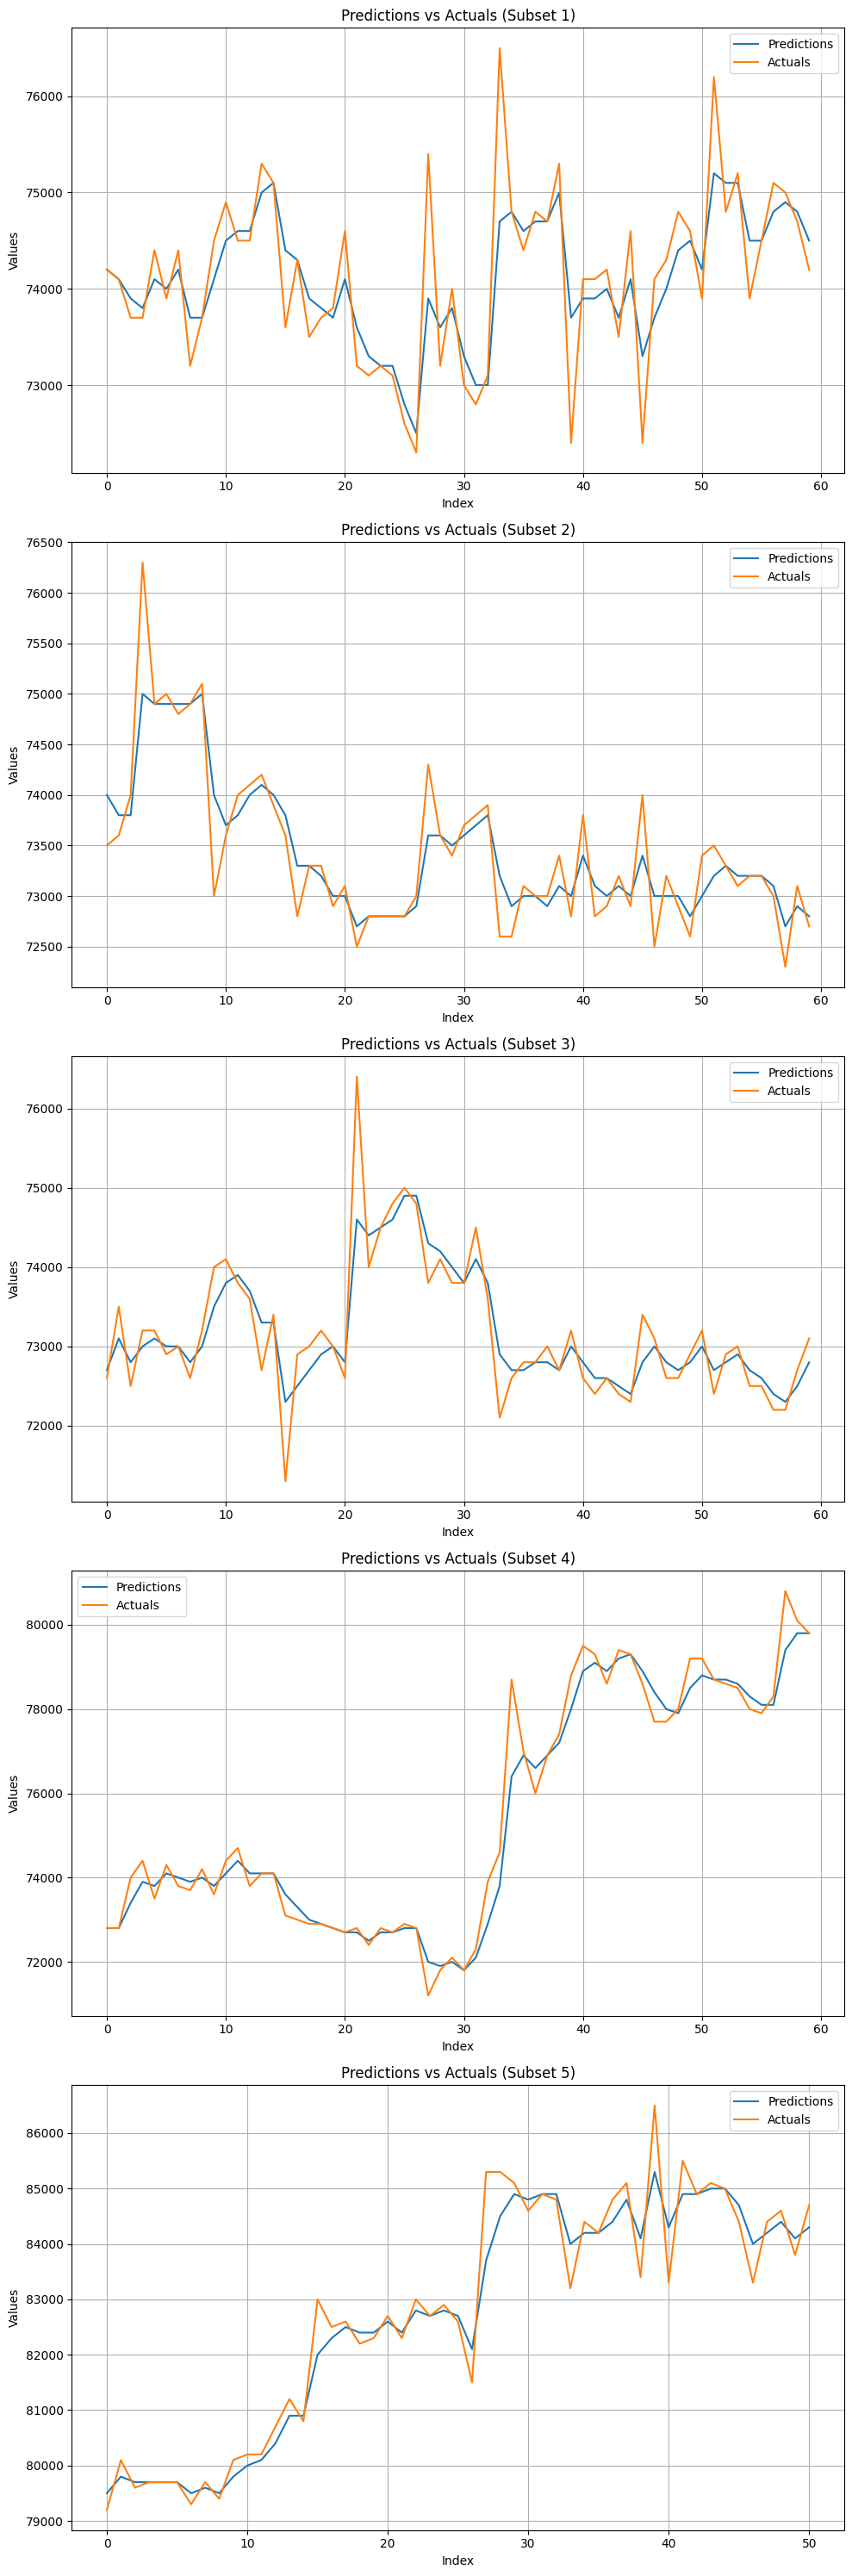

In [109]:
best_seq_len=5
best_p=0.1
best_epoch=70
best_patience=5
best_lr=0.001

stock=Stock(df)
stock.preprocessing()
stock.add_change(stock.df.columns)
stock.df.loc[stock.df['Volume_chg']==np.inf,'Volume_chg']=0
# stock.scale_col(stock.df.columns[[3,0,1,2,4]]) # 종가
stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)
train_loader=stock.data_loader(best_seq_len, 'train')
valid_loader=stock.data_loader(best_seq_len, 'valid')
test_loader=stock.data_loader(best_seq_len, 'test')
stock.create_model(1, best_p)
stock.model.load_state_dict(torch.load('chg_close_loss.pth'))
loss=stock.train(train_loader, valid_loader, test_loader, best_epoch//best_patience, best_lr, best_epoch, 'test')
pred, act=stock.pred_value('chg')
stock.diff()
stock.show('chg')

In [92]:
# torch.save(stock.model.state_dict(), 'close.pth')
# torch.save(stock.model.state_dict(), 'chg_close.pth')

수익률계산

In [152]:
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

names=['상승', '약한 상승', '횡보', '약한 하락', '하락']

best_price_roll=-np.inf
best_price_diff=-np.inf
shorts=[120, 240, 360, 480]
longs=[2, 3, 4, 5, 6]
ks = np.arange(0, 1.5, 0.1)
price_arr=[]
price_arr2=[]

short_long_combinations = list(itertools.product(shorts, longs))
hyperparameter_combinations = [(short, long, None) for short, long in short_long_combinations] + [(None, None, k) for k in ks]


for short, long, k in hyperparameter_combinations:
    for name in names:
        if name=='상승':
            df_get=pd.read_csv('strong_up_mico_m.csv')
            df_pred=pd.read_csv('strong_up_mico_h.csv')
        if name=='약한 상승':
            df_get=pd.read_csv('weak_up_polarisAI_m.csv')
            df_pred=pd.read_csv('weak_up_polarisAI_h.csv')
        if name=='횡보':
            df_get=pd.read_csv('horizonal_hansinmecha_m.csv')
            df_pred=pd.read_csv('horizonal_hansinmecha_h.csv')
        if name=='약한 하락':
            df_get=pd.read_csv('weak_down_gaonchips_m.csv')
            df_pred=pd.read_csv('weak_down_gaonchips_h.csv')
        if name=='하락':
            df_get=pd.read_csv('strong_down_studiomyre_m.csv')
            df_pred=pd.read_csv('strong_down_studiomyre_h.csv')
        stock.df=df_pred.copy()
        df_pred=stock.preprocessing()
        stock.add_change(stock.df.columns)
        stock.df.loc[stock.df['Volume_chg']==np.inf,'Volume_chg']=0
        stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)
        test_loader=stock.data_loader(best_seq_len, 't')
        stock.create_model()
        stock.model.load_state_dict(torch.load('chg_close_diff.pth'))
        stock.train(train_loader, valid_loader, test_loader, 7, 0.001, 80, 'test')
        pred, act=stock.pred_value('t')
        # stock.diff()
        # stock.show('chg')

        # 데이터셋 예측값 합치기
        stock.df=df_get.copy()
        df_get=stock.preprocessing()
        df_pred['pred']=0
        df_pred.iloc[len(df_pred)-len(pred):,-1]=pred
        df_get['key']=pd.to_datetime(df_get.index).strftime('%d-%H')
        df_pred['key']=pd.to_datetime(df_pred.index).strftime('%d-%H')
        df_get.loc[:,'pred']=pd.merge(df_get[['key']], df_pred[['key', 'pred']], how='left', on='Datetime')['pred']
        df_get.fillna(method='ffill', inplace=True)
        df_get[pd.to_datetime(df_get.index).strftime('%M')=='00']

        if k==None:
            # 이평선
            df_get['4H_MA'] = df_get['Close'].rolling(window=short).mean()
            df_get['8H_MA'] = df_get['Close'].rolling(window=short*long).mean()
            # 이전 행의 4H_MA와 8H_MA 비교를 위해 shift() 사용
            df_get['Previous_4H_MA'] = df_get['4H_MA'].shift(1)
            df_get['Previous_8H_MA'] = df_get['8H_MA'].shift(1)

            # 매수 조건: 이전 4H_MA <= 이전 8H_MA 이고 현재 4H_MA > 현재 8H_MA
            df_get['Buy_Signal'] = (df_get['Previous_4H_MA'] <= df_get['Previous_8H_MA']) & (df_get['4H_MA'] > df_get['8H_MA'])

            # 매도 조건: 각 시간대의 마지막 분(59분)에 매도
            # df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59
            df_get['Sell_Signal'] = (df_get['Previous_4H_MA'] >= df_get['Previous_8H_MA']) & (df_get['4H_MA'] < df_get['8H_MA'])

            results=[]
            moneys=[]
            money=[]
            first=[]
            key=False
            for i, row in df_get.iterrows():
                if row['Buy_Signal'] and row['Open']<=row['pred']:
                    money.append(row['Open'])
                    key=True
                if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
                    results.append((row['Close']-money[0])/money[0]*100)
                    moneys.append(row['Close']-money[0])
                    first.append(money[0])
                    money=[]
                    key=False
            try:
                # print('-'*100)
                # print(f'이동평균선 / {name}')
                # print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
                # print(f'모델 수익: {int(sum(moneys))}')
                # print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
                # print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
                # print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
                # print(f'매매횟수: {len(moneys)}')
                price=round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)
                buy_hold=round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)
            except:
                print('매매하지 않음')

            price_arr.append(price)
        
        else:
            # 변동성 돌파 전략
            df_pred['Point']=(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
            df_pred['Point2']=-(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
            df_get['Point']=pd.merge(df_get[['key']], df_pred[['key', 'Point']], how='left', on='Datetime')['Point']
            df_get['Point2']=pd.merge(df_get[['key']], df_pred[['key', 'Point2']], how='left', on='Datetime')['Point2']
            df_get['Point'].fillna(method='ffill', inplace=True)
            df_get['Point2'].fillna(method='ffill', inplace=True)

            df_get['Buy_Signal'] = (df_get['Point'] <= df_get['Open'])
            df_get['Sell_Signal'] = (df_get['Point2'] >= df_get['Open'])

            moneys=[]
            money=[]
            first=[]
            key=False
            for i, row in df_get.iterrows():
                if row['Buy_Signal'] and row['Open']<=row['pred']:
                    money.append(row['Open'])
                    key=True
                if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
                    moneys.append(row['Close']-money[0])
                    first.append(money[0])
                    money=[]
                    key=False
            try:
                # print('-'*100)
                # print(f'변동성 돌파 전략 / {name}')
                # print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
                # print(f'모델 수익: {int(sum(moneys))}')
                # print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
                # print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
                # print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
                # print(f'매매횟수: {len(moneys)}')
                price2=round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)
                buy_hold2=round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)

            except:
                print('매매하지 않음')
            
            price_arr2.append(price2)

    if np.mean(price_arr)>best_price_roll:
        print(f'{np.mean(price_arr)}가 {best_price_roll}보다 높았다.')
        print(f'하이퍼 파라미터: {short}, {long}')
        best_price_roll=price
        best_short=short
        best_long=long
    price_arr=[]

    if np.mean(price_arr2)>best_price_diff:
        print(f'{np.mean(price_arr2)}가 {best_price_diff}보다 높았다.')
        print(f'하이퍼 파라미터: {k}')
        best_price_diff=price2
        best_k=k
    price_arr2=[]

Average Test Loss: 0.03519046027213335
Average Test Loss: 0.04430674513181051
Average Test Loss: 0.05779013658563296
Average Test Loss: 0.02268147903184096
Average Test Loss: 0.06000330174962679
매매하지 않음
0.16060000000000002가 -inf보다 높았다.
하이퍼 파라미터: 120, 2
Average Test Loss: 0.03519046027213335
Average Test Loss: 0.04430674513181051
Average Test Loss: 0.05779013658563296
Average Test Loss: 0.02268147903184096
Average Test Loss: 0.06000330174962679
매매하지 않음
Average Test Loss: 0.03519046027213335
Average Test Loss: 0.04430674513181051
Average Test Loss: 0.05779013658563296
Average Test Loss: 0.02268147903184096
Average Test Loss: 0.06000330174962679
매매하지 않음
0.9822000000000001가 0.175보다 높았다.
하이퍼 파라미터: 120, 4
Average Test Loss: 0.03519046027213335
Average Test Loss: 0.04430674513181051
Average Test Loss: 0.05779013658563296
Average Test Loss: 0.02268147903184096
Average Test Loss: 0.06000330174962679
매매하지 않음
Average Test Loss: 0.03519046027213335
매매하지 않음
Average Test Loss: 0.04430674513181051
Av

In [153]:
print(best_k, best_short, best_long)

1.4000000000000001 240 5


In [154]:
for name in names:
    if name=='상승':
        df_get=pd.read_csv('strong_up_mico_m.csv')
        df_pred=pd.read_csv('strong_up_mico_h.csv')
    if name=='약한 상승':
        df_get=pd.read_csv('weak_up_polarisAI_m.csv')
        df_pred=pd.read_csv('weak_up_polarisAI_h.csv')
    if name=='횡보':
        df_get=pd.read_csv('horizonal_hansinmecha_m.csv')
        df_pred=pd.read_csv('horizonal_hansinmecha_h.csv')
    if name=='약한 하락':
        df_get=pd.read_csv('weak_down_gaonchips_m.csv')
        df_pred=pd.read_csv('weak_down_gaonchips_h.csv')
    if name=='하락':
        df_get=pd.read_csv('strong_down_studiomyre_m.csv')
        df_pred=pd.read_csv('strong_down_studiomyre_h.csv')
    stock.df=df_pred.copy()
    df_pred=stock.preprocessing()
    stock.add_change(stock.df.columns)
    stock.df.loc[stock.df['Volume_chg']==np.inf,'Volume_chg']=0
    stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)
    test_loader=stock.data_loader(best_seq_len, 't')
    stock.create_model()
    stock.model.load_state_dict(torch.load('chg_close_diff.pth'))
    stock.train(train_loader, valid_loader, test_loader, 7, 0.001, 80, 'test')
    pred, act=stock.pred_value('t')
    # stock.diff()
    # stock.show('chg')

    # 데이터셋 예측값 합치기
    stock.df=df_get.copy()
    df_get=stock.preprocessing()
    df_pred['pred']=0
    df_pred.iloc[len(df_pred)-len(pred):,-1]=pred
    df_get['key']=pd.to_datetime(df_get.index).strftime('%d-%H')
    df_pred['key']=pd.to_datetime(df_pred.index).strftime('%d-%H')
    df_get.loc[:,'pred']=pd.merge(df_get[['key']], df_pred[['key', 'pred']], how='left', on='Datetime')['pred']
    df_get.fillna(method='ffill', inplace=True)
    df_get[pd.to_datetime(df_get.index).strftime('%M')=='00']

    short=best_short
    long=best_long

    # 이평선
    df_get['4H_MA'] = df_get['Close'].rolling(window=short).mean()
    df_get['8H_MA'] = df_get['Close'].rolling(window=short*long).mean()
    # 이전 행의 4H_MA와 8H_MA 비교를 위해 shift() 사용
    df_get['Previous_4H_MA'] = df_get['4H_MA'].shift(1)
    df_get['Previous_8H_MA'] = df_get['8H_MA'].shift(1)

    # 매수 조건: 이전 4H_MA <= 이전 8H_MA 이고 현재 4H_MA > 현재 8H_MA
    df_get['Buy_Signal'] = (df_get['Previous_4H_MA'] <= df_get['Previous_8H_MA']) & (df_get['4H_MA'] > df_get['8H_MA'])

    # 매도 조건: 각 시간대의 마지막 분(59분)에 매도
    # df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59
    df_get['Sell_Signal'] = (df_get['Previous_4H_MA'] >= df_get['Previous_8H_MA']) & (df_get['4H_MA'] < df_get['8H_MA'])

    results=[]
    moneys=[]
    money=[]
    first=[]
    key=False
    for i, row in df_get.iterrows():
        if row['Buy_Signal'] and row['Open']<=row['pred']:
            money.append(row['Open'])
            key=True
        if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
            results.append((row['Close']-money[0])/money[0]*100)
            moneys.append(row['Close']-money[0])
            first.append(money[0])
            money=[]
            key=False
    try:
        print('-'*100)
        print(f'이동평균선 / {name}')
        print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
        print(f'모델 수익: {int(sum(moneys))}')
        print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
        print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
        print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
        print(f'매매횟수: {len(moneys)}')
    except:
        print('매매하지 않음')

    k=best_k
    # 변동성 돌파 전략
    df_pred['Point']=(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
    df_pred['Point2']=-(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
    df_get['Point']=pd.merge(df_get[['key']], df_pred[['key', 'Point']], how='left', on='Datetime')['Point']
    df_get['Point2']=pd.merge(df_get[['key']], df_pred[['key', 'Point2']], how='left', on='Datetime')['Point2']
    df_get['Point'].fillna(method='ffill', inplace=True)
    df_get['Point2'].fillna(method='ffill', inplace=True)

    df_get['Buy_Signal'] = (df_get['Point'] <= df_get['Open'])
    df_get['Sell_Signal'] = (df_get['Point2'] >= df_get['Open'])

    moneys=[]
    money=[]
    first=[]
    key=False
    for i, row in df_get.iterrows():
        if row['Buy_Signal'] and row['Open']<=row['pred']:
            money.append(row['Open'])
            key=True
        if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
            moneys.append(row['Close']-money[0])
            first.append(money[0])
            money=[]
            key=False
    try:
        print('-'*100)
        print(f'변동성 돌파 전략 / {name}')
        print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
        print(f'모델 수익: {int(sum(moneys))}')
        print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
        print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
        print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
        print(f'매매횟수: {len(moneys)}')

    except:
        print('매매하지 않음')

Average Test Loss: 0.03519046027213335
----------------------------------------------------------------------------------------------------
이동평균선 / 상승
매매하지 않음
----------------------------------------------------------------------------------------------------
변동성 돌파 전략 / 상승
모델 수익률: 0.269%
모델 수익: 40
수수료 포함 수익률: -0.131%
buy & hold 수익률: 21.71%
buy & hold 수익: 2870
매매횟수: 2
Average Test Loss: 0.04430674513181051
----------------------------------------------------------------------------------------------------
이동평균선 / 약한 상승
매매하지 않음
----------------------------------------------------------------------------------------------------
변동성 돌파 전략 / 약한 상승
모델 수익률: 1.255%
모델 수익: 45
수수료 포함 수익률: 0.855%
buy & hold 수익률: 5.507%
buy & hold 수익: 190
매매횟수: 2
Average Test Loss: 0.05779013658563296
----------------------------------------------------------------------------------------------------
이동평균선 / 횡보
모델 수익률: 0.825%
모델 수익: 40
수수료 포함 수익률: 0.625%
buy & hold 수익률: 0.208%
buy & hold 수익: 10
매매횟수: 1
----------